# 데이터 수집
- NEXON Open API : https://openapi.nexon.com/ko/game/maplestory/?id=14
- 캐릭터 정보 참고 : https://maple.gg/

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import time
import json
import glob
import os
import re
import aiohttp
import asyncio
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from urllib.parse import quote
from aiohttp import ClientSession

## JSON 추출
- 조회 기준일 : 2025-04-15
- 대상 월드 : 전체
- 페이지 : 1~5
⇒ 직업별 1,000개 명단 추출
- '대상 클래스 리스트' 및 저장 경로 변경하여 타직업 추출

In [ ]:
## 마법사 추출

# 날짜 및 API 키 설정
date = "2025-04-15"
API_KEY = "live_4bb9fe2d9c5f88d6d4d0fae33b021fd47a586db57c1872bf6649cad9965e1621efe8d04e6d233bd35cf2fabdeb93fb0d"
HEADERS = {"x-nxopen-api-key": API_KEY}

# 대상 클래스 리스트
# ✅ 바꿔서 사용할 것!
target_classes = [
    "마법사-아크메이지(불,독)",
    "마법사-아크메이지(썬,콜)",
    "마법사-비숍",
    "기사단-플레임위자드",
    "레지스탕스-배틀메이지",
    "에반-전체 전직",
    "루미너스-전체 전직",
    "일리움-전체 전직",
    "라라-전체 전직",
    "프렌즈 월드-키네시스"
]

# character 및 user 관련 endpoint 리스트
character_endpoints = [
    "item-equipment", "stat", "hyper-stat", "ability",
    "vmatrix", "hexamatrix", "symbol-equipment",
    "set-effect", "link-skill", "hexamatrix-stat"
]

user_endpoints = [
    "union", "union-raider", "union-artifact", "union-champion"
]

# JSON 요청 함수
async def fetch_json(session: ClientSession, url: str, params: dict):
    try:
        async with session.get(url, headers=HEADERS, params=params) as response:
            if response.status == 200:
                return await response.json()
            else:
                print(f"❌ 실패: {url} | 상태코드: {response.status}")
    except Exception as e:
        print(f"❌ 예외 발생: {url} | {e}")
    return {}

# ocid로 캐릭터 상세 데이터 가져오기
async def fetch_character_data(session: ClientSession, character):
    ocid_url = "https://open.api.nexon.com/maplestory/v1/id"
    ocid_params = {
        "character_name": character["nickname"],
        "world_name": character["world"]
    }
    ocid_data = await fetch_json(session, ocid_url, ocid_params)
    ocid = ocid_data.get("ocid")
    if not ocid:
        print(f"❗ocid 못 찾음 → 닉네임: {character['nickname']} | 월드: {character['world']}")
        return None

    if "-" in character["class"]:
        job, subclass = character["class"].split("-")
    else:
        job = subclass = character["class"]

    if subclass == "전체 전직":
        subclass = job

    result = {
        "nickname": character["nickname"],
        "world": character["world"],
        "level": character["level"],
        "rank": character["rank"],
        "job": job,
        "subclass": subclass
    }

    # character 관련 데이터 수집
    for ep in character_endpoints:
        url = f"https://open.api.nexon.com/maplestory/v1/character/{ep}"
        data = await fetch_json(session, url, {"ocid": ocid, "date": date})
        result[ep] = data

    # user 관련 데이터 수집(유니온)
    for ep in user_endpoints:
        url = f"https://open.api.nexon.com/maplestory/v1/user/{ep}"
        data = await fetch_json(session, url, {"ocid": ocid, "date": date})
        result[ep] = data

    return result

# 클래스별 랭킹 수집
async def gather_rankings_for_class(session, class_name):
    character_list = []
    for page in range(1, 6):  # 페이지당 200명 * 5페이지 = 총 1,000명 추출
        params = {
            "date": date,
            "class": class_name,
            "page": page
        }
        data = await fetch_json(session, "https://open.api.nexon.com/maplestory/v1/ranking/overall", params)
        if not data or "ranking" not in data:
            break
        for entry in data["ranking"]:
            character_list.append({
                "nickname": entry.get("character_name"),
                "world": entry.get("world_name"),
                "level": entry.get("character_level"),
                "rank": entry.get("ranking"),
                "class": class_name
            })
        await asyncio.sleep(0.1)
    return character_list

# 전체 실행 함수
async def main():
    save_dir = "/content/drive/MyDrive/data/마법사_stat추가" # ✅ 바꿔서 사용할 것!
    os.makedirs(save_dir, exist_ok=True)

    async with ClientSession() as session:
        for class_name in target_classes:
            print(f"📥 {class_name} 수집 시작")
            character_list = await gather_rankings_for_class(session, class_name)
            results = []
            tasks = [fetch_character_data(session, char) for char in character_list]
            for i in range(0, len(tasks), 50):
                chunk = tasks[i:i + 50]
                chunk_results = await asyncio.gather(*chunk)
                results.extend([r for r in chunk_results if r])
                await asyncio.sleep(0.2)

            df = pd.DataFrame(results)
            safe_class_name = class_name.replace("-", "_")
            df.to_json(f"{save_dir}/{safe_class_name}.json", orient="records", force_ascii=False)
            print(f"✅ 저장 완료: {safe_class_name}.json")

    return "완료!"

await main()

#### 확인용

In [ ]:
# JSON 불러오기
df = pd.read_json("/content/drive/MyDrive/data/stat추가/마법사_비숍.json")

df.head()

In [ ]:
# 첫 번째 row의 열 전체 출력
print(json.dumps(df['stat'][0], indent=2, ensure_ascii=False))

In [ ]:
# 첫 번째 row를 기준으로 모든 컬럼 출력
for col in df.columns:
    print(f"\n🟡 [{col}] ------------------------------")

    value = df[col][0]

    # dict나 list 타입이면 보기 좋게 JSON 정렬 출력
    if isinstance(value, (dict, list)):
        print(json.dumps(value, indent=2, ensure_ascii=False))
    else:
        print(value)

## CSV 변환
- 파일명 및 json 경로 변경하여 타직업 추출

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### item-equipment

In [ ]:
# ✅ 바꿔서 사용할 것!
job_class = "루미너스_전체 전직"   # 한글 파일명
job_class_eng = "luminous"         # 영문 파일명

# JSON 파일 불러오기
with open(f"/content/maple/magician_json/{job_class}.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# 캐릭터별 장비 데이터 추출
rows = []
for char in data:
    base_info = {
        "nickname": char.get("nickname"),
        "world": char.get("world"),
        "level": char.get("level"),
        "job": char.get("job"),
        "subclass": char.get("subclass"),
        # "gender": char.get("item-equipment", {}).get("character_gender"), # 캐릭터 성별
        # "preset_no": char.get("item-equipment", {}).get("preset_no"), # 적용 중인 장비 프리셋 번호
        # 예 : 카데나 랭킹 1위 별왕은 4/15 기준 프리셋이 3(으)로 설정되어있음
        # 예 : 카데나 랭킹 4위 사슬낫의제니는 4/15 기준 프리셋이 2로 설정되어있음
    }

    # 프리셋 설정
    preset_keys = [
        "item_equipment_preset_1",
        "item_equipment_preset_2",
        "item_equipment_preset_3"
    ]

    for preset_idx, preset_key in enumerate(preset_keys, start=1):
        items = char.get("item-equipment", {}).get(preset_key, [])
        for item in items:
            row = base_info.copy()
            row["preset_number"] = preset_idx # 프리셋 번호
            row["equipment_part"] = item.get("item_equipment_part") # 장비 부위 명
            row["equipment_slot"] = item.get("item_equipment_slot") # 장비 슬롯 위치
            row["item_name"] = item.get("item_name") # 이름
            # 장비 설명, 장비 외형, 전용 성별은 제외

            ######################
            # itemTotalOption : 장비 최종 옵션

            row["str_total"] = item.get("item_total_option", {}).get("str") # 최종 능력치 str
            row["dex_total"] = item.get("item_total_option", {}).get("dex") # 최종 능력치 dex
            row["int_total"] = item.get("item_total_option", {}).get("int") # 최종 능력치 int
            row["luk_total"] = item.get("item_total_option", {}).get("luk") # 최종 능력치 luk
            row["max_hp_total"] = item.get("item_total_option", {}).get("max_hp") # 최종 능력치 max_hp
            row["max_mp_total"] = item.get("item_total_option", {}).get("max_mp") # 최종 능력치 max_mp
            row["attack_power_total"] = item.get("item_total_option", {}).get("attack_power") # 최종 능력치 attack_power
            row["magic_power_total"] = item.get("item_total_option", {}).get("magic_power") # 최종 능력치 magic_power
            row["armor_total"] = item.get("item_total_option", {}).get("armor") # 최종 능력치 armor
            row["speed_total"] = item.get("item_total_option", {}).get("speed") # 최종 능력치 speed
            row["jump_total"] = item.get("item_total_option", {}).get("jump") # 최종 능력치 jump
            row["boss_damage_total"] = item.get("item_total_option", {}).get("boss_damage") # 최종 능력치 boss_damage
            row["ignore_monster_armor_total"] = item.get("item_total_option", {}).get("ignore_monster_armor") # 최종 능력치 ignore_monster_armor
            row["all_stat_total"] = item.get("item_total_option", {}).get("all_stat") # 최종 능력치 all_stat
            row["damage_total"] = item.get("item_total_option", {}).get("damage") # 최종 능력치 damage
            row["equipment_level_decrease_total"] = item.get("item_total_option", {}).get("equipment_level_decrease") # 최종 능력치 equipment_level_decrease
            row["max_hp_rate_total"] = item.get("item_total_option", {}).get("max_hp_rate") # 최종 능력치 max_hp_rate
            row["max_mp_rate_total"] = item.get("item_total_option", {}).get("max_mp_rate") # 최종 능력치 max_mp_rate

            ######################
            # itemBaseOption : 장비 기본 옵션

            row["str_base"] = item.get("item_base_option", {}).get("str") # 기본 능력치 str
            row["dex_base"] = item.get("item_base_option", {}).get("dex") # 기본 능력치 dex
            row["int_base"] = item.get("item_base_option", {}).get("int") # 기본 능력치 int
            row["luk_base"] = item.get("item_base_option", {}).get("luk") # 기본 능력치 luk
            row["max_hp_base"] = item.get("item_base_option", {}).get("max_hp") # 기본 능력치 max_hp
            row["max_mp_base"] = item.get("item_base_option", {}).get("max_mp") # 기본 능력치 max_mp
            row["attack_power_base"] = item.get("item_base_option", {}).get("attack_power") # 기본 능력치 attack_power
            row["magic_power_base"] = item.get("item_base_option", {}).get("magic_power") # 기본 능력치 magic_power
            row["armor_base"] = item.get("item_base_option", {}).get("armor") # 기본 능력치 armor
            row["speed_base"] = item.get("item_base_option", {}).get("speed") # 기본 능력치 speed
            row["jump_base"] = item.get("item_base_option", {}).get("jump") # 기본 능력치 jump
            row["boss_damage_base"] = item.get("item_base_option", {}).get("boss_damage") # 기본 능력치 bose_damage
            row["ignore_monster_armor_base"] = item.get("item_base_option", {}).get("ignore_monster_armor") # 기본 능력치 ignore_monster_armor
            row["all_stat_base"] = item.get("item_base_option", {}).get("all_stat") # 기본 능력치 all_stat
            row["max_hp_rate_base"] = item.get("item_base_option", {}).get("max_hp_rate") # 기본 능력치 max_hp_rate
            row["max_mp_rate_base"] = item.get("item_base_option", {}).get("max_mp_rate") # 기본 능력치 max_mp_rate
            row["base_equipment_level_base"] = item.get("item_base_option", {}).get("base_equipment_level") # 기본 능력치 base_equipment_level

            ######################
            # 잠재능력 + 에디셔널 잠재능력

            row["potential_option_grade"] = item.get("potential_option_grade") # 잠재능력 등급
            row["additional_potential_option_grade"] = item.get("additional_potential_option_grade") # 에디셔널 잠재능력 등급
            # row["potential_option_flag"] = item.get("potential_option_flag")
            row["potential_option_1"] = item.get("potential_option_1") # 잠재능력 1
            row["potential_option_2"] = item.get("potential_option_2") # 잠재능력 2
            row["potential_option_3"] = item.get("potential_option_3") # 잠재능력 3
            # row["additional_potential_option_flag"] = item.get("additional_potential_option_flag")
            row["additional_potential_option_1"] = item.get("additional_potential_option_1") # 에디셔널 잠재능력 1
            row["additional_potential_option_2"] = item.get("additional_potential_option_2") # 에디셔널 잠재능력 2
            row["additional_potential_option_3"] = item.get("additional_potential_option_3") # 에디셔널 잠재능력 3
            row["equipment_level_increase"] = item.get("equipment_level_increase") # 착용 레벨 증가

            ######################
            # itemExceptionalOption : 장비 특별 옵션

            row["str_exceptional"] = item.get("item_exceptional_option", {}).get("str") # 특별 능력치 str
            row["dex_exceptional"] = item.get("item_exceptional_option", {}).get("dex") # 특별 능력치 dex
            row["int_exceptional"] = item.get("item_exceptional_option", {}).get("int") # 특별 능력치 int
            row["luk_exceptional"] = item.get("item_exceptional_option", {}).get("luk") # 특별 능력치 luk
            row["max_hp_exceptional"] = item.get("item_exceptional_option", {}).get("max_hp") # 특별 능력치 max_hp
            row["max_mp_exceptional"] = item.get("item_exceptional_option", {}).get("max_mp") # 특별 능력치 max_mp
            row["attack_power_exceptional"] = item.get("item_exceptional_option", {}).get("attack_power") # 특별 능력치 attack_power
            row["magic_power_exceptional"] = item.get("item_exceptional_option", {}).get("magic_power") # 특별 능력치 magic_power
            row["exceptional_upgrade"] = item.get("item_exceptional_option", {}).get("exceptional_upgrade") # 익셉셔널 강화 적용 횟수

            ######################
            # itemAddOption : 장비 추가 옵션

            row["str_add"] = item.get("item_add_option", {}).get("str") # 추가 능력치 str
            row["dex_add"] = item.get("item_add_option", {}).get("dex") # 추가 능력치 dex
            row["int_add"] = item.get("item_add_option", {}).get("int") # 추가 능력치 int
            row["luk_add"] = item.get("item_add_option", {}).get("luk") # 추가 능력치 luk
            row["max_hp_add"] = item.get("item_add_option", {}).get("max_hp") # 추가 능력치 max_hp
            row["max_mp_add"] = item.get("item_add_option", {}).get("max_mp") # 추가 능력치 max_mp
            row["attack_power_add"] = item.get("item_add_option", {}).get("attack_power") # 추가 능력치 attack_power
            row["magic_power_add"] = item.get("item_add_option", {}).get("magic_power") # 추가 능력치 magic_power
            row["armor_add"] = item.get("item_add_option", {}).get("armor") # 추가 능력치 armor
            row["speed_add"] = item.get("item_add_option", {}).get("speed") # 추가 능력치 speed
            row["jump_add"] = item.get("item_add_option", {}).get("jump") # 추가 능력치 jump
            row["boss_damage_add"] = item.get("item_add_option", {}).get("boss_damage") # 추가 능력치 boss_damage
            row["damage_add"] = item.get("item_add_option", {}).get("damage") # 추가 능력치 damage
            row["all_stat_add"] = item.get("item_add_option", {}).get("all_stat") # 추가 능력치 all_stat
            row["equipment_level_decrease_add"] = item.get("item_add_option", {}).get("equipment_level_decrease") # 착용 레벨 감소

            ######################
            # itemEtcOption : 장비 기타 옵션

            row["str_etc"] = item.get("item_etc_option", {}).get("str") # 기타 능력치 str
            row["dex_etc"] = item.get("item_etc_option", {}).get("dex") # 기타 능력치 dex
            row["int_etc"] = item.get("item_etc_option", {}).get("int") # 기타 능력치 int
            row["luk_etc"] = item.get("item_etc_option", {}).get("luk") # 기타 능력치 luk
            row["max_hp_etc"] = item.get("item_etc_option", {}).get("max_hp") # 기타 능력치 max_hp
            row["max_mp_etc"] = item.get("item_etc_option", {}).get("max_mp") # 기타 능력치 max_mp
            row["attack_power_etc"] = item.get("item_etc_option", {}).get("attack_power") # 기타 능력치 attack_power
            row["magic_power_etc"] = item.get("item_etc_option", {}).get("magic_power") # 기타 능력치 magic_power
            row["armor_etc"] = item.get("item_etc_option", {}).get("armor") # 기타 능력치 armor
            row["speed_etc"] = item.get("item_etc_option", {}).get("speed") # 기타 능력치 speed
            row["jump_etc"] = item.get("item_etc_option", {}).get("jump") # 기타 능력치 jump

            ######################
            # itemStarforceOption : 장비 스타포스 옵션

            row["starforce"] = item.get("starforce") # 스타포스
            row["starforce_scroll_flag"] = item.get("starforce_scroll_flag") # 놀라운 장비 강화 주문서 사용 여부 (0:미사용, 1:사용)
            row["str_starforce"] = item.get("item_starforce_option", {}).get("str") # 스타포스 능력치 str
            row["dex_starforce"] = item.get("item_starforce_option", {}).get("dex") # 스타포스 능력치 dex
            row["int_starforce"] = item.get("item_starforce_option", {}).get("int") # 스타포스 능력치 int
            row["luk_starforce"] = item.get("item_starforce_option", {}).get("luk") # 스타포스 능력치 luk
            row["max_hp_starforce"] = item.get("item_starforce_option", {}).get("max_hp") # 스타포스 능력치 max_hp
            row["max_mp_starforce"] = item.get("item_starforce_option", {}).get("max_mp") # 스타포스 능력치 max_mp
            row["attack_power_starforce"] = item.get("item_starforce_option", {}).get("attack_power") # 스타포스 능력치 attack_power
            row["magic_power_starforce"] = item.get("item_starforce_option", {}).get("magic_power") # 스타포스 능력치 magic_power
            row["armor_starforce"] = item.get("item_starforce_option", {}).get("armor") # 스타포스 능력치 armor
            row["speed_starforce"] = item.get("item_starforce_option", {}).get("speed") # 스타포스 능력치 speed
            row["jump_starforce"] = item.get("item_starforce_option", {}).get("jump") # 스타포스 능력치 jump
            row["special_ring_level"] = item.get("special_ring_level") # 특수 반지 레벨
            # row["date_expire"] = item.get("item_starforce_option", {}).get("date_expire") # 장비 유효 기간

            ######################
            # 기타

            row["growth_exp"] = item.get("growth_exp") # 성장 경험치
            row["growth_level"] = item.get("growth_level") # 성장 레벨
            row["scroll_upgrade"] = item.get("scroll_upgrade") # 업그레이드 횟수
            row["cuttable_count"] = item.get("cuttable_count") # 가위 사용 가능 횟수 (교환 불가 장비, 가위 횟수가 없는 교환 가능 장비는 255)
            row["golden_hammer_flag"] = item.get("golden_hammer_flag") # 황금 망치 재련 적용 (1:적용, 이외 미 적용)
            row["scroll_resilience_count"] = item.get("scroll_resilience_count") # 복구 가능 횟수
            row["scroll_upgradeable_count"] = item.get("scroll_upgradeable_count") # 업그레이드 가능 횟수
            row["soul_name"] = item.get("soul_name") # 소울 명
            row["soul_option"] = item.get("soul_option") # 소울 옵션


            rows.append(row)

# DataFrame 생성
df = pd.DataFrame(rows)

# CSV 저장
df.to_csv(f"{job_class_eng}_equipment.csv", index=False, encoding="utf-8-sig")
print("CSV 저장 완료!")

----
# 가설 검정 및 시각화

In [ ]:
# item 데이터 모두 불러오기

# 상위 폴더 경로
root_dir = "/content/drive/MyDrive/data/item" # 수정

# 하위 모든 CSV 탐색
all_csv_files = glob.glob(os.path.join(root_dir, "*/*.csv"))

df_list = []
for file in all_csv_files:
    df = pd.read_csv(file)
    folder_name = os.path.basename(os.path.dirname(file))
    job_file = os.path.basename(file).replace("_equipment.csv", "") # 수정
    df["job_group"] = folder_name
    df_list.append(df)

# 전체 통합
item_df = pd.concat(df_list, ignore_index=True) # 수정

In [ ]:
# 메이플의 장비 프리셋은 총 3개 -> 가장 추가옵션이 높은 프리셋 하나만 사용하여 분석

# 직업별 주스탯 맵핑
main_stat_map = {
    "STR": ["히어로", "아델", "소울마스터", "아란", "제로", "팔라딘", "다크나이트", "카이저",
            "데몬슬레이어", "미하일", "블래스터", "은월", "바이퍼", "스트라이커", "캐논마스터"],
    "DEX": ["윈드브레이커", "메르세데스", "보우마스터", "패스파인더", "신궁", "카인", "와일드헌터",
            "엔젤릭버스터", "캡틴", "메카닉"],
    "INT": ["비숍", "아크메이지(불,독)", "아크메이지(썬,콜)", "라라", "배틀메이지", "에반", "루미너스",
            "키네시스", "플레임위자드", "일리움"],
    "LUK": ["나이트워커", "섀도어", "나이트로드", "듀얼블레이더", "팬텀", "호영", "칼리", "카데나"],
    "HP": ["데몬어벤져"],
    "ALL": ["제논"]
}

def get_main_stat(row):
    for stat, jobs in main_stat_map.items():
        if row["job"] in jobs:
            return stat
    return None

item_df["main_stat_type"] = item_df.apply(get_main_stat, axis=1)

# 추옵 계산 함수
def calculate_bonus_stat(row):
    stat = row["main_stat_type"]
    if stat is None:
        return 0
    allstat = row["all_stat_add"] * 10
    if stat == "INT":
        return row["int_add"] + allstat + row["magic_power_add"] * 4
    elif stat == "HP":
        return row["attack_power_add"] * 150 + row["max_hp_add"] + allstat
    elif stat == "ALL":
        return row["str_add"] + row["dex_add"] + row["luk_add"] + row["attack_power_add"] * 6 + allstat
    else:
        return row[f"{stat.lower()}_add"] + allstat + row["attack_power_add"] * 4

item_df["bonus_stat_total"] = item_df.apply(calculate_bonus_stat, axis=1)

# 유저별 + 부위별 가장 높은 bonus_stat_total을 가진 프리셋만 추출
item_df_best = (
    item_df.loc[item_df.groupby(["nickname", "equipment_part"])["bonus_stat_total"].idxmax()]
    .reset_index(drop=True)
)

In [ ]:
item_df_best.info(max_cols=300)

## 가설 1
----

앱솔랩스(중하위권 장비)를 사용하는 경우, 아케인셰이드(중상위권), 에테르넬(상위권) 장비에 비해 강화 수치 22성의 개수가 더 많을 것이다.

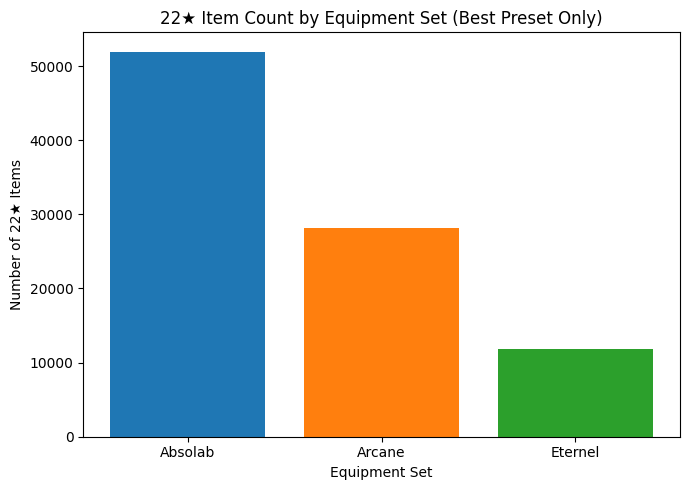

In [ ]:
# 장비 세트 그룹 정의
def map_equipment_group(name):
    if "앱솔랩스" in name:
        return "Absolab"
    elif "아케인셰이드" in name:
        return "Arcane"
    elif "에테르넬" in name:
        return "Eternel"
    return None

# 세트명 매핑 및 필터링
item_df_best["equip_group"] = item_df_best["item_name"].apply(map_equipment_group)
filtered = item_df_best[item_df_best["equip_group"].notnull()].copy()

# 22성 여부 컬럼 추가
filtered["is_22star"] = (filtered["starforce"] == 22).astype(int)

# 세트별 22성 장비 개수 집계
group_counts = (
    filtered
    .groupby("equip_group")["is_22star"]
    .sum()
    .reindex(["Absolab", "Arcane", "Eternel"], fill_value=0)
)

# 시각화
plt.figure(figsize=(7, 5))
bars = plt.bar(group_counts.index, group_counts.values, color=["#1f77b4", "#ff7f0e", "#2ca02c"])

# 수치 라벨 표시
# for bar in bars:
#     height = bar.get_height()
#     plt.annotate(f"{int(height):,}",  # 쉼표 포함 숫자 표시
#                  xy=(bar.get_x() + bar.get_width() / 2, height),
#                  xytext=(0, 3),
#                  textcoords="offset points",
#                  ha="center", va="bottom", fontsize=9)

plt.title("22★ Item Count by Equipment Set (Best Preset Only)")
plt.xlabel("Equipment Set")
plt.ylabel("Number of 22★ Items")
plt.tight_layout()
plt.show()

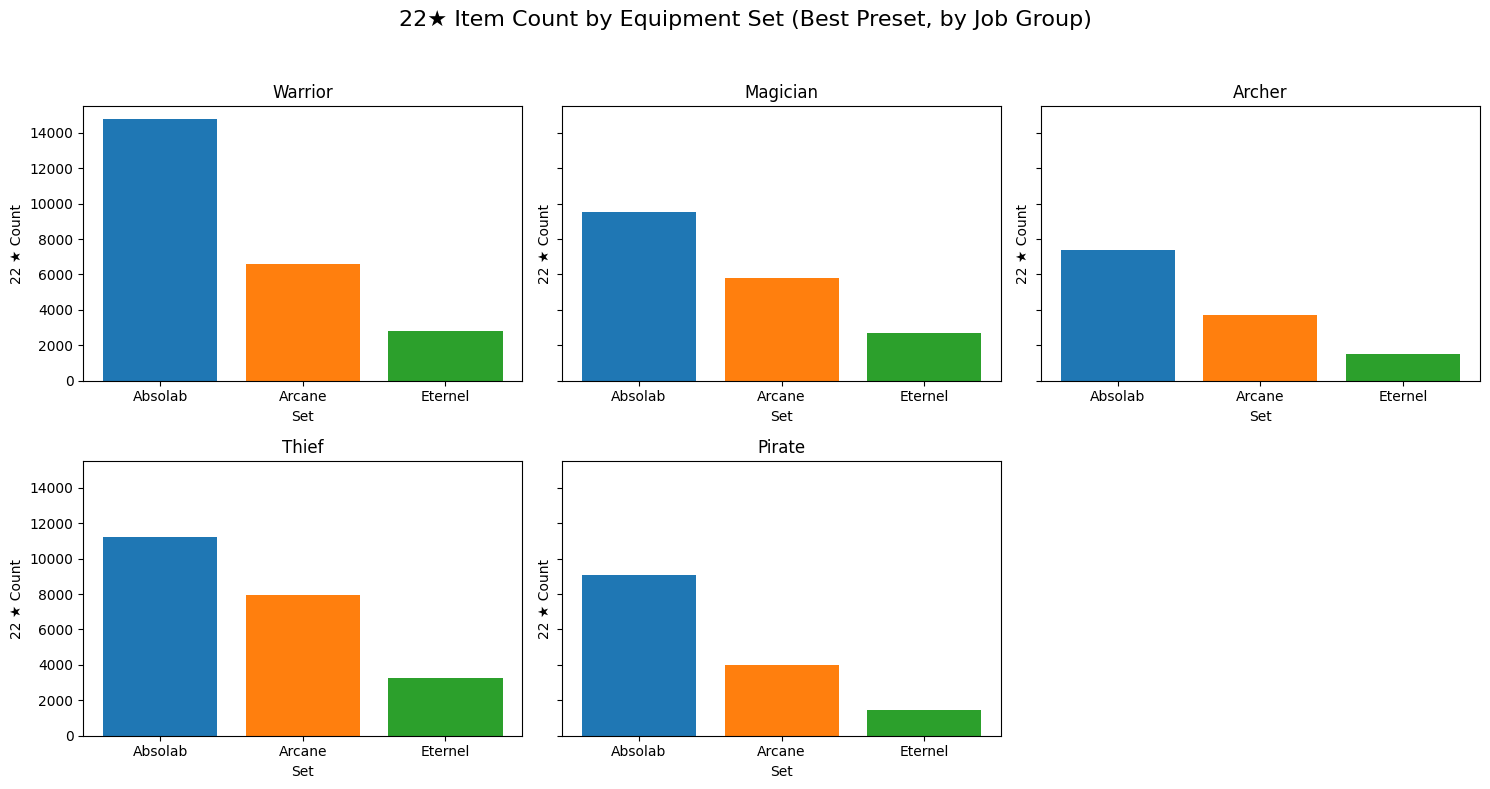

In [ ]:
# 직업군별로 살펴보기

# 유니코드 정규화 + 직업군 영어 매핑
item_df_best["job_group"] = item_df_best["job_group"].apply(lambda x: unicodedata.normalize("NFC", x))
group_map = {
    "전사": "Warrior", "마법사": "Magician", "궁수": "Archer", "도적": "Thief", "해적": "Pirate"
}
item_df_best["job_group_eng"] = item_df_best["job_group"].map(group_map)

# 장비 세트 분류
def map_equipment_group(name):
    if "앱솔랩스" in name:
        return "Absolab"
    elif "아케인셰이드" in name:
        return "Arcane"
    elif "에테르넬" in name:
        return "Eternel"
    return None

item_df_best["equip_group"] = item_df_best["item_name"].apply(map_equipment_group)
filtered = item_df_best[item_df_best["equip_group"].notnull()].copy()
filtered["is_22star"] = (filtered["starforce"] == 22).astype(int)

# 직업군 리스트
job_groups = ["Warrior", "Magician", "Archer", "Thief", "Pirate"]
colors = {"Absolab": "#1f77b4", "Arcane": "#ff7f0e", "Eternel": "#2ca02c"}

# subplot 시각화
n_cols = 3
n_rows = (len(job_groups) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), sharey=True)
axes = axes.flatten()

for idx, group in enumerate(job_groups):
    ax = axes[idx]
    sub = filtered[filtered["job_group_eng"] == group]
    count = (
        sub.groupby("equip_group")["is_22star"]
        .sum()
        .reindex(["Absolab", "Arcane", "Eternel"], fill_value=0)
    )
    bars = ax.bar(count.index, count.values, color=[colors[k] for k in count.index])

    ax.set_title(group)
    ax.set_xlabel("Set")
    ax.set_ylabel("22 ★ Count")
    ax.tick_params(axis="x", rotation=0)

    # for bar in bars:
    #     height = bar.get_height()
    #     ax.annotate(f"{int(height):,}",  # 쉼표 있는 숫자
    #                 xy=(bar.get_x() + bar.get_width() / 2, height),
    #                 xytext=(0, 2),
    #                 textcoords="offset points",
    #                 ha="center", va="bottom", fontsize=9)

# 빈 subplot 제거
for j in range(len(job_groups), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("22★ Item Count by Equipment Set (Best Preset, by Job Group)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

시각화 결과: 앱솔랩스 장비에서 그 윗단계인 아케인셰이드, 에테르넬 장비에 비해 22성의 개수가 더 많다. **(기존 가설
 = TRUE)**
- 또한 모든 직업군에서 같은 경향성이 보였다.

### 추론 통계

In [ ]:
# 장비 등급과 강화 구간(22성 vs 미만) 사이의 독립성 여부 검정: 카이제곱 독립성 검정

# 교차표
crosstab = pd.crosstab(filtered["equip_group"], filtered["is_22star"])

# 카이제곱 검정
chi2, pval, dof, expected = chi2_contingency(crosstab)

# 크래머의 V
n = crosstab.sum().sum()
min_dim = min(crosstab.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")
print(f"Cramér's V: {cramers_v:.4f}")

Chi-square: 16879.199, p-value: 0.0000
Cramér's V: 0.2820


- 귀무가설(H₀): 장비 등급과 22성 강화 여부는 서로 독립이다. (장비 등급에 상관없이 22성 강화 여부가 비슷함)
- 대립가설(H₁): 장비 등급과 22성 강화 여부는 서로 독립이 아니다. (장비 등급에 따라 22성 강화 여부가 달라짐)
  - **p-value < α(0.05)로, 대립가설을 채택하여 장비 등급에 따라 22성 강화 여부가 달라진다고 할 수 있다.**
  - 또한 **Cramér’s V = 0.2820**은 **두 변수 간의 관계 강도가 약한 수준에서 중간 수준에 가까운 명확한 경향성을 가진다**는 점을 보여주며,
이는 **장비 강화 전략에서 등급에 따른 뚜렷한 경향성이 실질적으로 존재함**을 의미한다.

In [ ]:
# 직업군마다 이러한 경향이 일관되게 나타나는가?: 직업군별로 개별 카이제곱 독립성 검정
job_groups = filtered["job_group_eng"].unique()

results = []

for job in job_groups:
    subset = filtered[filtered["job_group_eng"] == job]
    table = pd.crosstab(subset["equip_group"], subset["is_22star"])

    if table.shape[0] > 1 and table.shape[1] > 1:  # 예외 처리
        chi2, pval, dof, expected = chi2_contingency(table)

        results.append({
            "job_group": job,
            "chi2": chi2,
            "p_value": pval,
            "significant": pval < 0.05
        })

pd.DataFrame(results)

,job_group,chi2,p_value,significant
0,Pirate,4606.490601,0.0,True
1,Warrior,4416.813702,0.0,True
2,Archer,2666.146313,0.0,True
3,Thief,3195.452344,0.0,True
4,Magician,2680.703522,0.0,True


- 귀무가설(H₀): 장비 등급과 22성 강화 여부는 서로 독립이다. (장비 등급에 상관없이 22성 강화 여부가 비슷함)
- 대립가설(H₁): 장비 등급과 22성 강화 여부는 서로 독립이 아니다. (장비 등급에 따라 22성 강화 여부가 달라짐)
  - **모든 직업군에서 p-value < α(0.05)로, 대립가설을 채택하여 각 직업군 내에서
장비 등급과 22성 강화 여부는 통계적으로 유의미하게 관련되어 있다고 할 수 있다.**

### **최종 정리**
----
장비 등급이 낮을수록 유저들이 **22성 아이템을 더 적극적으로 사용하는 경향**이 존재하며,
이 경향은 전체 유저는 물론, **모든 직업군에서 일관되게 확인**되었다.

특히 앱솔랩스 장비의 경우, **강화 비용 대비 효율, 접근성, 강화 난이도** 등 다양한 요인을 고려한
**전략적 선택의 결과로 22성 비율이 유의미하게 높게 나타난 것**으로 해석할 수 있다.

결과적으로, **장비 강화 전략에서 ‘장비 등급’은 실질적으로 매우 중요한 영향 요인**임이 통계적으로 뒷받침되었다.

## 가설 2
----

아이템이 고가일수록 잠재능력과 에디셔널의 등급이 둘 다 레전드리인 비율은 낮을것이다.

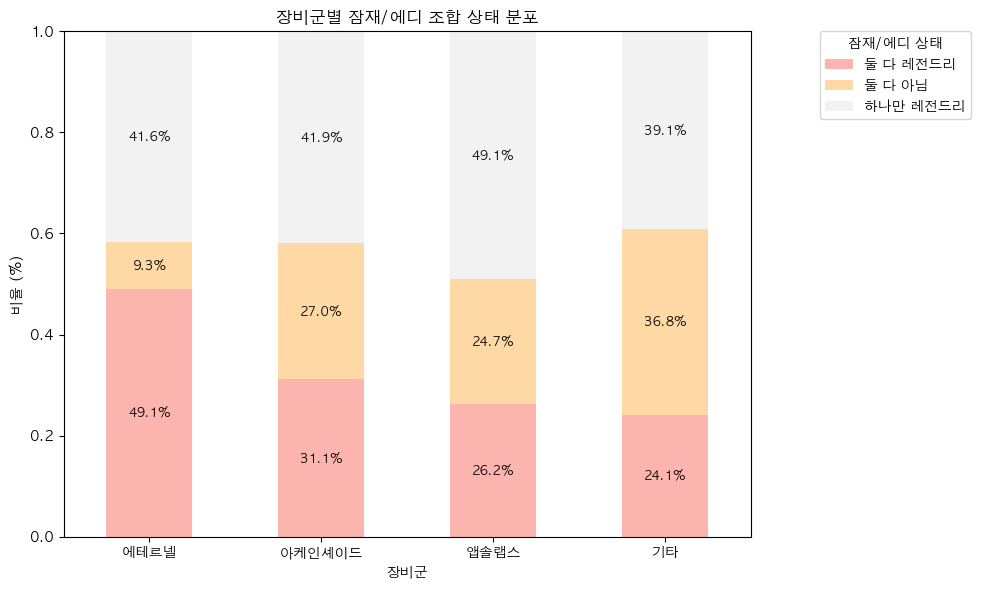

In [ ]:
# 파일 불러오기
df = pd.read_csv("data/item_equipment/merged/total_item_merged.csv")

# 장비군 분류 함수
def categorize_item(name):
    if '앱솔랩스' in name:
        return '앱솔랩스'
    elif '아케인셰이드' in name:
        return '아케인셰이드'
    elif '에테르넬' in name:
        return '에테르넬'
    else:
        return '기타'

df['장비군'] = df['item_name'].apply(categorize_item)

# 잠재/에디 조합 상태 구분
def categorize_potential(row):
    pot = row['potential_option_grade']
    add = row['additional_potential_option_grade']
    if pot == '레전드리' and add == '레전드리':
        return '둘 다 레전드리'
    elif pot == '레전드리' or add == '레전드리':
        return '하나만 레전드리'
    else:
        return '둘 다 아님'

df['잠재상태'] = df.apply(categorize_potential, axis=1)

# 장비군 순서 고정
order = ['에테르넬', '아케인셰이드', '앱솔랩스', '기타']
df['장비군'] = pd.Categorical(df['장비군'], categories=order, ordered=True)

# 교차표 비율 계산
status_ratio = df.groupby(['장비군', '잠재상태'], observed=False).size().unstack().fillna(0)
status_ratio = status_ratio.div(status_ratio.sum(axis=1), axis=0)  # 비율로 변환

# 누적 막대그래프
ax = status_ratio.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Pastel1')
plt.title('장비군별 잠재/에디 조합 상태 분포')
plt.ylabel('비율 (%)')
plt.ylim(0, 1)
plt.xticks(rotation=0)
# plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='잠재/에디 상태', loc='upper left', bbox_to_anchor=(1.1, 1), borderaxespad=0.)
plt.tight_layout()

# 수치 라벨 추가
for i, (index, row) in enumerate(status_ratio.iterrows()):
    cum_sum = 0
    for category in status_ratio.columns:
        value = row[category]
        if value > 0.02:  # 2% 이상일 때만 표시
            ax.text(
                i, cum_sum + value / 2,
                f'{value*100:.1f}%',
                ha='center', va='center', fontsize=9, color='black'
            )
        cum_sum += value

plt.show()

### 추론 통계

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

# 교차표 생성 (장비군 vs 잠재상태)
contingency_table = pd.crosstab(df['장비군'], df['잠재상태'])

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Cramér's V 계산
n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

# 출력
print("Chi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", p)
print("Cramér's V:", cramers_v)

# 해석
alpha = 0.05
if p < alpha:
    print("귀무가설 기각: 장비군과 잠재/에디 조합 상태는 독립이 아님 → 상관관계 있음.")
else:
    print("귀무가설 채택: 장비군과 잠재/에디 조합 상태는 독립임 → 상관관계 없음.")

Chi-square statistic: 75903.93090995013
Degrees of freedom: 6
P-value: 0.0
Cramér's V: 0.10901068206905731
귀무가설 기각: 장비군과 잠재/에디 조합 상태는 독립이 아님 → 상관관계 있음.


### 최종 정리
----
해석 및 결과
- 해석 : 각 방어구 세트와 잠재/에디 상태 간의 차이를 시각화한 결과, 카이제곱 검정에서 유의미한 차이(p-value < 0.05)는 있었지만, 효과크기(Cramér's V = 0.109)는 매우 작아 가격대와 옵션간의 관계의 크기는 미미함

- 결과 : 아이템이 고가일수록 잠재능력과 에디셔널의 등급이 둘 다 레전드리인 비율은 높지만, 그 관계의 크기(상관성)는 매우 작음

## 가설 3
----

많은 유저들이 아이템 레벨별 '최소 수준'에 해당하는 급 이상의 추가옵션을 사용하고 있을 것이다.

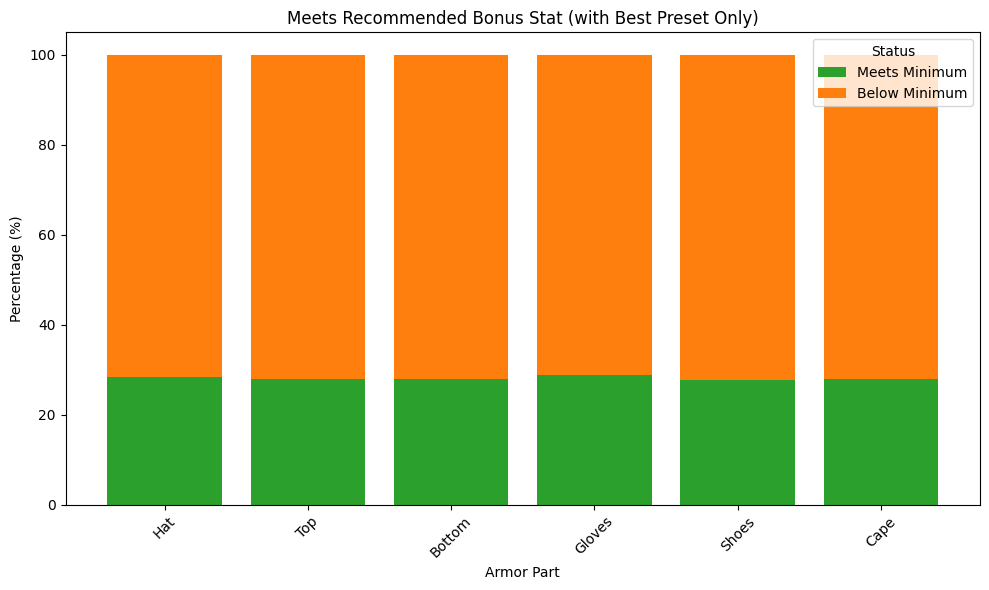

In [ ]:
# 방어구 부위별 '국민추옵' 수치 충족 여부 확인

# 방어구 부위별 맵핑
armor_name_map = {
    "모자": "Hat", "상의": "Top", "하의": "Bottom",
    "장갑": "Gloves", "신발": "Shoes", "망토": "Cape" # 어깨장식의 경우 추옵이 붙지 않아 제외
}
armor_order = ["Hat", "Top", "Bottom", "Gloves", "Shoes", "Cape"]

def get_main_stat(row):
    for stat, jobs in main_stat_map.items():
        if row["job"] in jobs:
            return stat
    return None

item_df_best["main_stat_type"] = item_df_best.apply(get_main_stat, axis=1)

def get_minimum_threshold(level, stat_type):
    if stat_type == "HP":
        return level * 15
    elif stat_type == "ALL":
        if level >= 250:
            return 330
        elif level >= 200:
            return 280
        elif level >= 160:
            return 240
        elif level >= 150:
            return 230
        elif level >= 140:
            return 220
    else:
        if level >= 250:
            return 160
        elif level >= 200:
            return 140
        elif level >= 160:
            return 120
        elif level >= 140:
            return 110
    return None

def calculate_bonus_stat(row):
    stat = row["main_stat_type"]
    if stat is None:
        return None
    allstat = row["all_stat_add"] * (20 if stat == "ALL" else 10)
    if stat == "HP":
        return row["attack_power_add"] * 150 + row["max_hp_add"]
    elif stat == "ALL":
        return row["str_add"] + row["dex_add"] + row["luk_add"] + row["attack_power_add"] * 6 + allstat
    elif stat == "INT":
        return row["int_add"] + allstat + row["magic_power_add"] * 4
    else:
        return row[f"{stat.lower()}_add"] + allstat + row["attack_power_add"] * 4

item_df_best["bonus_stat_total"] = item_df_best.apply(calculate_bonus_stat, axis=1)
item_df_best["recommended_min"] = item_df_best.apply(
    lambda row: get_minimum_threshold(row["base_equipment_level_base"], row["main_stat_type"]), axis=1
)
item_df_best["meets_minimum"] = item_df_best["bonus_stat_total"] >= item_df_best["recommended_min"]
item_df_best["equipment_part_eng"] = item_df_best["equipment_part"].map(armor_name_map)

filtered = item_df_best[item_df_best["equipment_part_eng"].isin(armor_order)]
part_group = filtered.groupby(["equipment_part_eng", "meets_minimum"]).size().unstack().fillna(0)
percent_df = part_group.div(part_group.sum(axis=1), axis=0) * 100
percent_df = percent_df.reindex(armor_order)

# 시각화
colors = {True: "#2ca02c", False: "#ff7f0e"}
bottom = None
plt.figure(figsize=(10, 6))
for label in [True, False]:
    plt.bar(
        percent_df.index,
        percent_df[label],
        bottom=bottom,
        label="Meets Minimum" if label else "Below Minimum",
        color=colors[label]
    )
    bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

plt.title("Meets Recommended Bonus Stat (with Best Preset Only)")
plt.ylabel("Percentage (%)")
plt.xlabel("Armor Part")
plt.xticks(rotation=45)
plt.legend(title="Status")
plt.tight_layout()
plt.show()

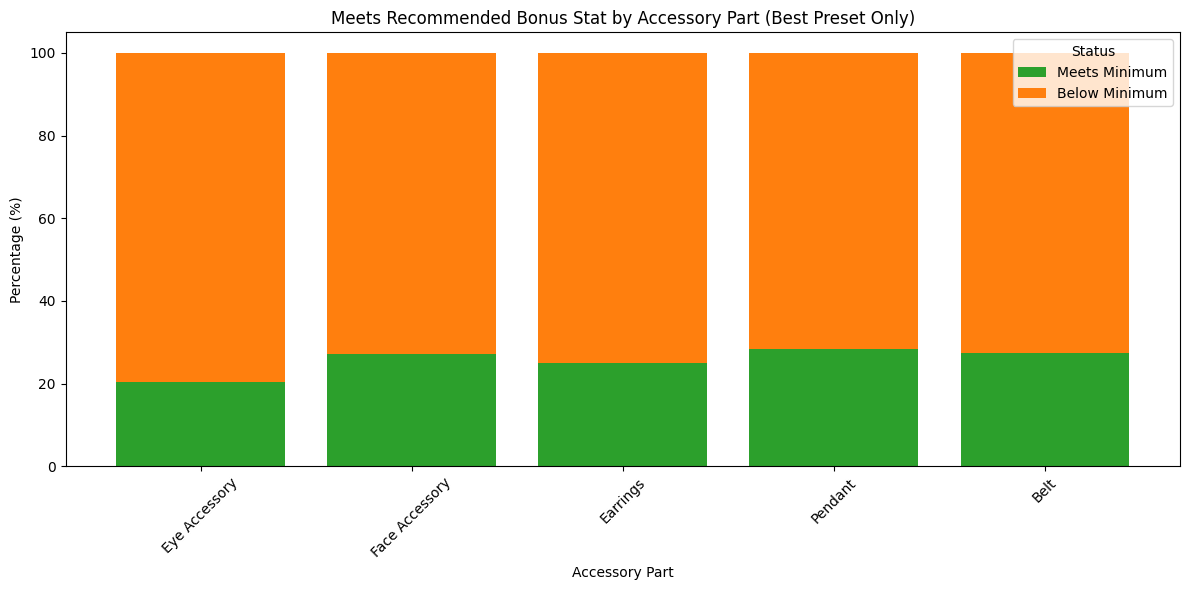

In [ ]:
# 장신구 부위별 '국민추옵' 수치 충족 여부 확인

# 장신구 이름 매핑
accessory_name_map = {
    "눈장식": "Eye Accessory", "얼굴장식": "Face Accessory", "벨트": "Belt",
    "펜던트": "Pendant", "귀고리": "Earrings"
}
accessory_order = [accessory_name_map[k] for k in ["눈장식", "얼굴장식", "귀고리", "펜던트", "벨트"]]

def get_main_stat(row):
    for stat, jobs in main_stat_map.items():
        if row["job"] in jobs:
            return stat
    return None

item_df_best["main_stat_type"] = item_df_best.apply(get_main_stat, axis=1)

def get_minimum_threshold(level, stat_type):
    if stat_type == "HP":
        return level * 15
    elif stat_type == "ALL":
        if level >= 250: return 330
        elif level >= 200: return 280
        elif level >= 160: return 240
        elif level >= 150: return 230
        elif level >= 140: return 220
    else:
        if level >= 250: return 160
        elif level >= 200: return 140
        elif level >= 160: return 120
        elif level >= 140: return 110
    return None

def calculate_bonus_stat(row):
    stat = row["main_stat_type"]
    if stat is None: return None
    allstat = row["all_stat_add"] * (20 if stat == "ALL" else 10)
    if stat == "HP":
        return row["attack_power_add"] * 150 + row["max_hp_add"] + allstat
    elif stat == "ALL":
        return row["str_add"] + row["dex_add"] + row["luk_add"] + row["attack_power_add"] * 6 + allstat
    elif stat == "INT":
        return row["int_add"] + allstat + row["magic_power_add"] * 4
    else:
        return row[f"{stat.lower()}_add"] + allstat + row["attack_power_add"] * 4

item_df_best["bonus_stat_total"] = item_df_best.apply(calculate_bonus_stat, axis=1)
item_df_best["recommended_min"] = item_df_best.apply(
    lambda row: get_minimum_threshold(row["base_equipment_level_base"], row["main_stat_type"]), axis=1
)
item_df_best["meets_minimum"] = item_df_best["bonus_stat_total"] >= item_df_best["recommended_min"]
item_df_best["equipment_part_eng"] = item_df_best["equipment_part"].map(accessory_name_map)

filtered = item_df_best[item_df_best["equipment_part_eng"].isin(accessory_order)]
part_group = filtered.groupby(["equipment_part_eng", "meets_minimum"]).size().unstack().fillna(0)
part_group.columns = part_group.columns.astype(str)

# 누락된 열 추가 (문자열로 체크)
for col in ["True", "False"]:
    if col not in part_group.columns:
        part_group[col] = 0

# 순서 고정
part_group = part_group[["True", "False"]]

# 비율 계산
percent_df = part_group.div(part_group.sum(axis=1), axis=0) * 100
percent_df = percent_df.reindex(accessory_order)

# 시각화
colors = {"True": "#2ca02c", "False": "#ff7f0e"}
bottom = None

plt.figure(figsize=(12, 6))
for label in ["True", "False"]:
    plt.bar(
        percent_df.index,
        percent_df[label],
        bottom=bottom,
        label="Meets Minimum" if label == "True" else "Below Minimum",
        color=colors[label]
    )
    bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

plt.title("Meets Recommended Bonus Stat by Accessory Part (Best Preset Only)")
plt.ylabel("Percentage (%)")
plt.xlabel("Accessory Part")
plt.xticks(rotation=45)
plt.legend(title="Status")
plt.tight_layout()
plt.show()

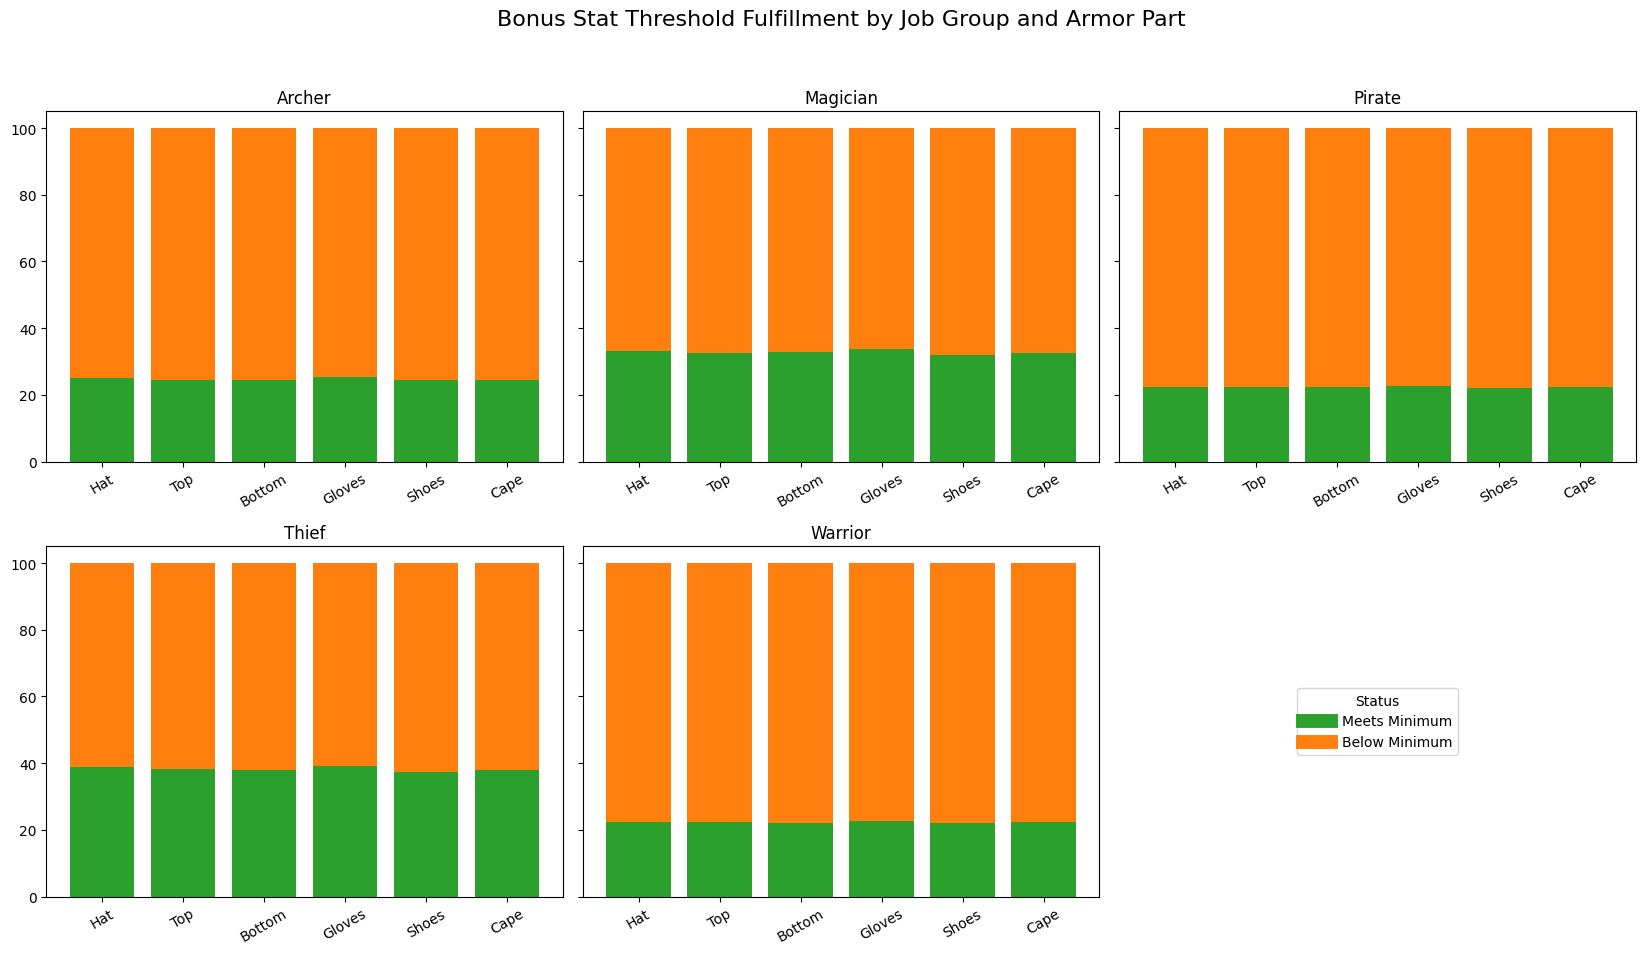

In [ ]:
# 방어구 부위별 '국민추옵' 수치 충족 여부 확인(직업군별로 살펴보기)

# 한글 문자열에 유니코드 정규화 적용
item_df_best["job_group"] = item_df_best["job_group"].apply(lambda x: unicodedata.normalize("NFC", x))

# 직업군 매핑
job_group_map = {
    "전사": "Warrior",
    "마법사": "Magician",
    "궁수": "Archer",
    "도적": "Thief",
    "해적": "Pirate"
}
item_df_best["job_group_eng"] = item_df_best["job_group"].map(job_group_map)

# 방어구 부위별 맵핑
armor_name_map = {
    "모자": "Hat", "상의": "Top", "하의": "Bottom",
    "장갑": "Gloves", "신발": "Shoes", "망토": "Cape" # 어깨장식의 경우 추옵이 붙지 않아 제외
}
armor_order = ["Hat", "Top", "Bottom", "Gloves", "Shoes", "Cape"]
item_df_best["equipment_part_eng"] = item_df_best["equipment_part"].map(armor_name_map)

# 유효한 방어구 부위만 필터링
filtered = item_df_best[
    item_df_best["equipment_part_eng"].isin(armor_order) &
    item_df_best["job_group_eng"].notna()
]

# 직업군 리스트 생성
job_groups = sorted(filtered["job_group_eng"].unique())

# subplot 레이아웃 설정
n_cols = 3
n_rows = (len(job_groups) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10), sharey=True)
axes = axes.flatten()

colors = {True: "#2ca02c", False: "#ff7f0e"}

# 불필요한 subplot 인덱스 추적용
plotted_indices = []

# 직업군별 subplot 그리기
for i, group in enumerate(job_groups):
    ax = axes[i]
    plotted_indices.append(i)

    subset = filtered[filtered["job_group_eng"] == group]
    part_group = subset.groupby(["equipment_part_eng", "meets_minimum"]).size().unstack().fillna(0)
    part_group.columns = part_group.columns.astype(bool)

    percent_df = part_group.div(part_group.sum(axis=1), axis=0) * 100
    percent_df = percent_df.reindex(armor_order)

    bottom = None
    for label in [True, False]:
        ax.bar(
            percent_df.index,
            percent_df[label],
            bottom=bottom,
            label="Meets Minimum" if label else "Below Minimum",
            color=colors[label]
        )
        bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

    ax.set_title(group)
    ax.set_xticks(range(len(percent_df.index)))
    ax.set_xticklabels(percent_df.index, rotation=30)

# 빈 subplot에 범례 넣기
for j in range(len(axes)):
    if j not in plotted_indices:
        axes[j].axis("off")  # 축 꺼주고
        axes[j].legend(
            handles=[
                plt.Line2D([0], [0], color=colors[True], lw=10, label="Meets Minimum"),
                plt.Line2D([0], [0], color=colors[False], lw=10, label="Below Minimum")
            ],
            title="Status",
            loc='center'
        )

# 전체 제목 등 설정
fig.suptitle("Bonus Stat Threshold Fulfillment by Job Group and Armor Part", fontsize=16)
plt.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])
plt.show()

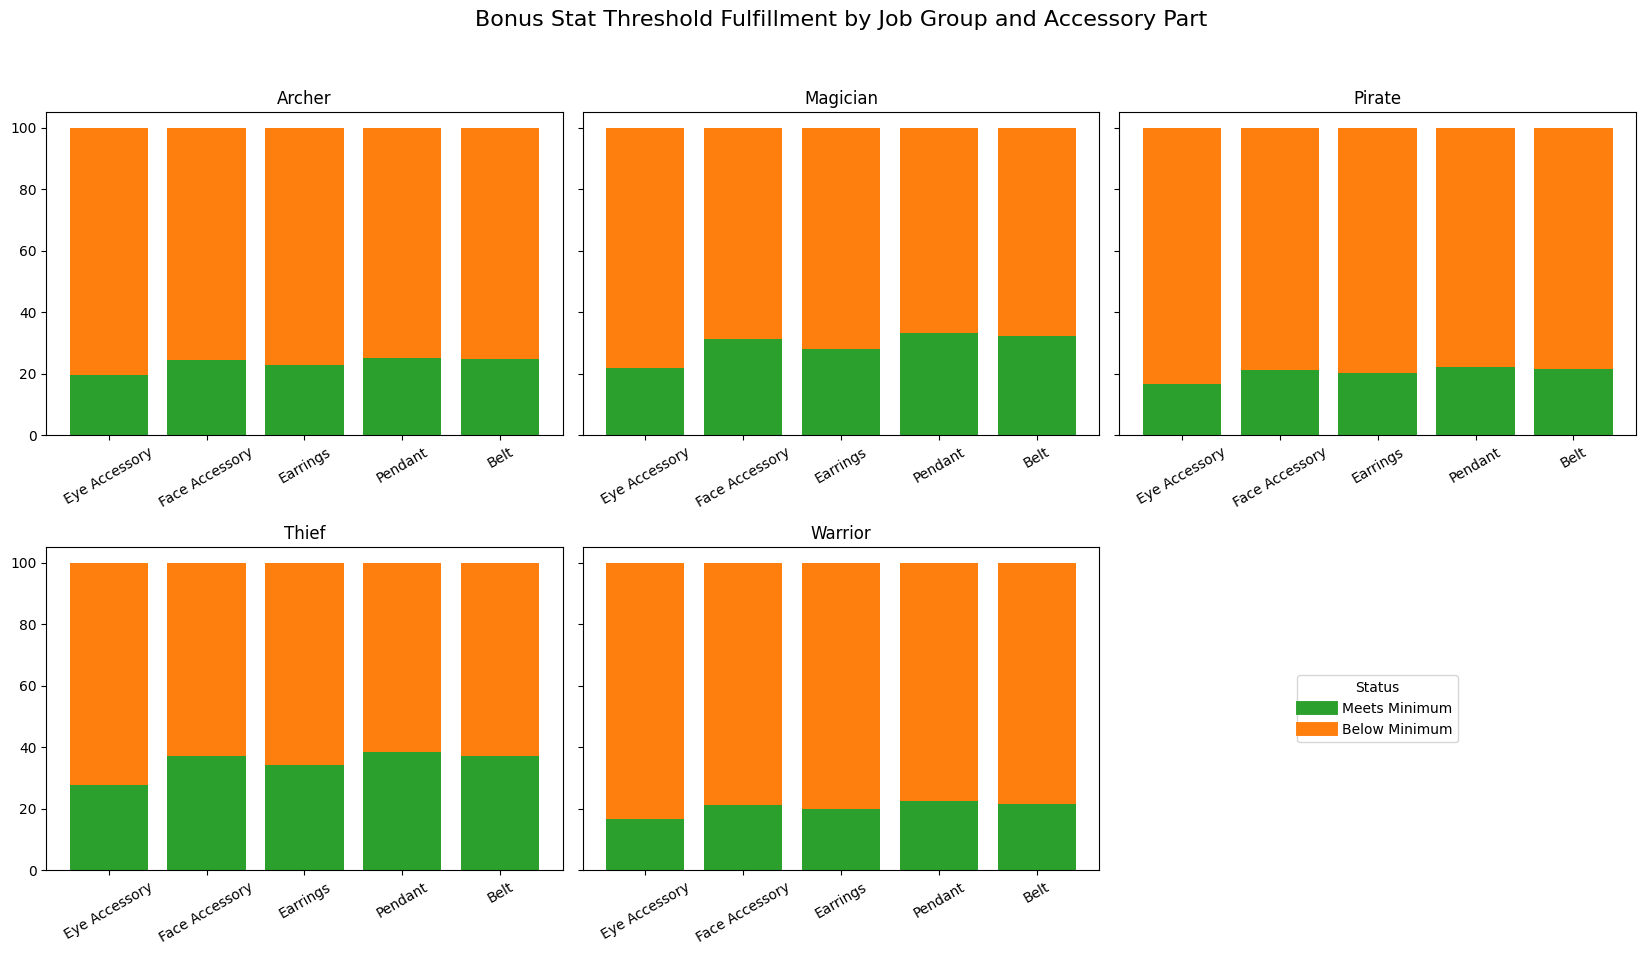

In [ ]:
# 장신구 부위별 '국민추옵' 수치 충족 여부 확인(직업군별로 살펴보기)

import unicodedata
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# 한글 문자열에 유니코드 정규화 적용
item_df_best["job_group"] = item_df_best["job_group"].apply(lambda x: unicodedata.normalize("NFC", x))

# 직업군 매핑
job_group_map = {
    "전사": "Warrior",
    "마법사": "Magician",
    "궁수": "Archer",
    "도적": "Thief",
    "해적": "Pirate"
}
item_df_best["job_group_eng"] = item_df_best["job_group"].map(job_group_map)

# 장신구 부위 이름 매핑
accessory_name_map = {
    "눈장식": "Eye Accessory",
    "얼굴장식": "Face Accessory",
    "벨트": "Belt",
    "펜던트": "Pendant",
    "귀고리": "Earrings"
}
accessory_order = [accessory_name_map[k] for k in ["눈장식", "얼굴장식", "귀고리", "펜던트", "벨트"]]

# 장신구 부위 매핑
item_df_best["equipment_part_eng"] = item_df_best["equipment_part"].map(accessory_name_map)

# 유효한 장신구 부위만 필터링
filtered = item_df_best[
    item_df_best["equipment_part_eng"].isin(accessory_order) &
    item_df_best["job_group_eng"].notna()
]

# 직업군 리스트 생성
job_groups = sorted(filtered["job_group_eng"].unique())

# subplot 레이아웃 설정
n_cols = 3
n_rows = (len(job_groups) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10), sharey=True)
axes = axes.flatten()

colors = {True: "#2ca02c", False: "#ff7f0e"}
plotted_indices = []

# 직업군별 subplot 그리기
for i, group in enumerate(job_groups):
    ax = axes[i]
    plotted_indices.append(i)

    subset = filtered[filtered["job_group_eng"] == group]
    part_group = subset.groupby(["equipment_part_eng", "meets_minimum"]).size().unstack().fillna(0)
    part_group.columns = part_group.columns.astype(bool)

    percent_df = part_group.div(part_group.sum(axis=1), axis=0) * 100
    percent_df = percent_df.reindex(accessory_order)

    bottom = None
    for label in [True, False]:
        ax.bar(
            percent_df.index,
            percent_df[label],
            bottom=bottom,
            label="Meets Minimum" if label else "Below Minimum",
            color=colors[label]
        )
        bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

    ax.set_title(group)
    ax.set_xticks(range(len(percent_df.index)))
    ax.set_xticklabels(percent_df.index, rotation=30)

# 빈 subplot에 범례 넣기
for j in range(len(axes)):
    if j not in plotted_indices:
        axes[j].axis("off")
        axes[j].legend(
            handles=[
                mlines.Line2D([0], [0], color=colors[True], lw=10, label="Meets Minimum"),
                mlines.Line2D([0], [0], color=colors[False], lw=10, label="Below Minimum")
            ],
            title="Status",
            loc='center'
        )

# 전체 제목 설정
fig.suptitle("Bonus Stat Threshold Fulfillment by Job Group and Accessory Part", fontsize=16)
plt.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])
plt.show()

시각화 결과: 추가옵션의 '최소 수준'을 국민추옵 기준으로 맞췄을 때, 방어구와 장신구 모두 많은 유저들이 그 기준을 넘지 못했다. **(기존 가설 = FALSE)**
  - 이러한 경향성은 모든 직업군에서 공통적으로 보였다.

### 추론 통계

In [ ]:
item_df_best["equipment_part_eng"].unique()

array(['Earrings', nan, 'Eye Accessory', 'Belt', 'Face Accessory',
       'Pendant'], dtype=object)

In [ ]:
# 전체 유저 기준(방어구): 카이제곱 적합도 검정

# 관측값
armor_counts = filtered["meets_minimum"].value_counts().to_dict()
armor_observed = [armor_counts.get(True, 0), armor_counts.get(False, 0)]

# 기대값 계산 및 검정
armor_expected = [sum(armor_observed) / 2] * 2
armor_chi2, armor_pval = chisquare(f_obs=armor_observed, f_exp=armor_expected)

print(f"Chi-square: {armor_chi2:.3f}, p-value: {armor_pval:.4f}")

Chi-square: 50706.229, p-value: 0.0000


- 귀무가설(H₀): 전체 유저 중 방어구에서 '국민추옵' 기준을 충족한 유저와 충족하지 못한 유저의 비율은 동일하다.
- 대립가설(H₁): 국민추옵 기준을 충족하지 못한 유저가 유의미하게 많다.
  - **p-value < α(0.05)로, 대립가설을 채택하여 전체 유저 중 방어구에서 국민추옵 기준을 충족하지 못한 유저가 유의미하게 많다고 할 수 있다.**

In [ ]:
# 전체 유저 기준(장신구): 카이제곱 적합도 검정

accessory_valid = item_df_best[
    item_df_best["equipment_part_eng"].isin(accessory_order) &
    item_df_best["meets_minimum"].isin([True, False])
]

# 관측값
accessory_counts = accessory_valid["meets_minimum"].value_counts().to_dict()
accessory_observed = [accessory_counts.get(True, 0), accessory_counts.get(False, 0)]

# 기대값 계산 및 검정
accessory_expected = [sum(accessory_observed) / 2] * 2
accessory_chi2, accessory_pval = chisquare(f_obs=accessory_observed, f_exp=accessory_expected)

print(f"Chi-square: {accessory_chi2:.3f}, p-value: {accessory_pval:.4f}")

Chi-square: 52527.605, p-value: 0.0000


- 귀무가설(H₀): 전체 유저 중 장신구에서 '국민추옵' 기준을 충족한 유저와 충족하지 못한 유저의 비율은 동일하다.
- 대립가설(H₁): 국민추옵 기준을 충족하지 못한 유저가 유의미하게 많다.
  - **p-value < α(0.05)로, 대립가설을 채택하여 전체 유저 중 장신구에서 국민추옵 기준을 충족하지 못한 유저가 유의미하게 많다고 할 수 있다.**

In [ ]:
# 직업군과 기준 충족 여부의 관련성 검정(방어구): 카이제곱 독립성 검정

# 교차표 (직업군 vs 기준 충족 여부)
crosstab = pd.crosstab(
    filtered["job_group_eng"],
    filtered["meets_minimum"]
)

# 카이제곱 독립성 검정
chi2, pval, dof, expected = chi2_contingency(crosstab)

# 크래머의 V
n = crosstab.sum().sum()
min_dim = min(crosstab.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")
print(f"Cramér’s V: {cramers_v:.4f}")

Chi-square: 5444.529, p-value: 0.0000
Cramér’s V: 0.1434


- 귀무가설(H₀): 직업군과 방어구의 '국민추옵 기준 충족 여부'는 서로 독립이다. (어떤 직업이든 기준을 충족하는 비율이 비슷)
- 대립가설(H₁): 직업군과 방어구의 '국민추옵 기준 충족 여부'는 서로 독립이 아니다. (직업군에 따라 기준 충족 비율이 다름)
  - **p-value < α(0.05)로, 대립가설을 채택하여 직업군에 따라 기준을 충족하는 비율이 서로 다르다는 사실이 통계적으로 입증되었다고 할 수 있다.**
  - 그러나 **Cramér’s V = 0.1434**로, **강한 상관까지는 아니며
직업군과 무관하게 비슷한 세팅 전략을 공유하는 유저들도 다수 존재함을 시사**한다.

In [ ]:
# 직업군과 기준 충족 여부의 관련성 검정(장신구): 카이제곱 독립성 검정

# 교차표 (직업군 vs 기준 충족 여부)
accessory_crosstab = pd.crosstab(
    accessory_valid["job_group_eng"],
    accessory_valid["meets_minimum"]
)

# 카이제곱 독립성 검정
accessory_chi2, accessory_pval, accessory_dof, accessory_expected = chi2_contingency(accessory_crosstab)

# 크래머의 V 계산
accessory_n = accessory_crosstab.to_numpy().sum()
accessory_min_dim = min(accessory_crosstab.shape) - 1
accessory_cramers_v = np.sqrt(accessory_chi2 / (accessory_n * accessory_min_dim))

print(f"Chi-square: {accessory_chi2:.3f}, p-value: {accessory_pval:.4f}")
print(f"Cramér’s V: {accessory_cramers_v:.4f}")

Chi-square: 3809.819, p-value: 0.0000
Cramér’s V: 0.1310


- 귀무가설(H₀): 직업군과 장신구의 '국민추옵 기준 충족 여부'는 서로 독립이다. (어떤 직업이든 기준을 충족하는 비율이 비슷)
- 대립가설(H₁): 직업군과 장신구의 '국민추옵 기준 충족 여부'는 서로 독립이 아니다. (직업군에 따라 기준 충족 비율이 다름)
  - **p-value < α(0.05)로, 대립가설을 채택하여 직업군에 따라 기준을 충족하는 비율이 서로 다르다는 사실이 통계적으로 입증되었다고 할 수 있다.**
  - 그러나 **Cramér’s V = 0.1310**으로 관련성은 **강하지 않으며,
전반적으로 유저들은 직업군과 무관하게 유사한 장신구 세팅을 하고 있는 경향이 강하다.**

### **최종 정리**
----
전체적으로 유저들은 아이템의 추가옵션에서 기대되는 '국민추옵' 기준을 충족하지 못하고 있는 경향이 강하며, 이 경향은 방어구와 장신구 모두에서 일관되게 나타난다.

직업군에 따라 어느 정도의 차이는 존재하지만, 그 영향력은 크지 않으며,
대부분의 유저들이 직업군을 불문하고 유사한 수준의 세팅 전략을 따르고 있다는 점에서 **'기준 미만의 추가옵션 사용'이 보편적 현실임이 통계적으로 입증되었다**고 볼 수 있다.

-----
# 전처리

- item.csv

In [ ]:
# 데이터 불러오기
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/data/preprocessing/item.csv", low_memory=False)

In [ ]:
# 전체 칼럼에 대한 정보 확인 -> 113 columns
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063724 entries, 0 to 1063723
Data columns (total 113 columns):
 #    Column                             Non-Null Count    Dtype  
---   ------                             --------------    -----  
 0    nickname                           1063724 non-null  object 
 1    world                              1063724 non-null  object 
 2    level                              1063724 non-null  int64  
 3    job                                1063724 non-null  object 
 4    subclass                           1063724 non-null  object 
 5    preset_number                      1063724 non-null  int64  
 6    equipment_part                     1063724 non-null  object 
 7    equipment_slot                     1063724 non-null  object 
 8    item_name                          1063724 non-null  object 
 9    str_total                          1063724 non-null  int64  
 10   dex_total                          1063724 non-null  int64  
 11   int_total

## (1) 불필요한 칼럼 제거

In [ ]:
# 불필요한 칼럼 드랍: 장비의 기본 능력치 정보
cols_to_drop = [
    "str_base", "dex_base", "int_base", "luk_base",
    "max_hp_base", "max_mp_base",
    "attack_power_base", "magic_power_base", "armor_base",
    "speed_base", "jump_base",
    "boss_damage_base", "ignore_monster_armor_base",
    "all_stat_base", "max_hp_rate_base", "max_mp_rate_base",
    "base_equipment_level_base"
]

df.drop(columns=cols_to_drop, inplace=True)

In [ ]:
df.info() # 96 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063724 entries, 0 to 1063723
Data columns (total 96 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   nickname                           1063724 non-null  object 
 1   world                              1063724 non-null  object 
 2   level                              1063724 non-null  int64  
 3   job                                1063724 non-null  object 
 4   subclass                           1063724 non-null  object 
 5   preset_number                      1063724 non-null  int64  
 6   equipment_part                     1063724 non-null  object 
 7   equipment_slot                     1063724 non-null  object 
 8   item_name                          1063724 non-null  object 
 9   str_total                          1063724 non-null  int64  
 10  dex_total                          1063724 non-null  int64  
 11  int_total               

### 장비 최종 옵션
----
전략: 주스탯에 맞지 않는 능력치 칼럼 제거 후 하나의 열로 통일

In [ ]:
# 직업별 주스탯 기준 열 삭제 코드
# 1. 주스탯에 맞지 않는 능력치 칼럼 제거
# 2. INT 직업은 attack_power_total 제거, 비 INT 직업은 magic_power_total 제거
# 3. 공통적으로 제거할 컬럼: armor, speed, jump, equipment_level_decrease, max_hp_rate, max_mp_rate
# 4. 보존 컬럼: boss_damage_total, ignore_monster_armor_total, all_stat_total, damage_total

# 주요 스탯 관련 열만 따로 정의
stat_related_cols = [
    "str_total", "dex_total", "int_total", "luk_total",
    "max_hp_total", "max_mp_total",
    "attack_power_total", "magic_power_total",
    "armor_total", "speed_total", "jump_total",
    "equipment_level_decrease_total", "max_hp_rate_total", "max_mp_rate_total",
    "boss_damage_total", "ignore_monster_armor_total", "all_stat_total", "damage_total"
]

# 2. 직업별 주스탯 매핑
main_stat_map = {
    "STR": ["히어로", "아델", "소울마스터", "아란", "제로", "팔라딘", "다크나이트", "카이저",
            "데몬슬레이어", "미하일", "블래스터", "은월", "바이퍼", "스트라이커", "캐논마스터", "아크"],
    "DEX": ["윈드브레이커", "메르세데스", "보우마스터", "패스파인더", "신궁", "카인", "와일드헌터",
            "엔젤릭버스터", "캡틴", "메카닉"],
    "INT": ["비숍", "아크메이지(불,독)", "아크메이지(썬,콜)", "라라", "배틀메이지", "에반", "루미너스",
            "키네시스", "플레임위자드", "일리움"],
    "LUK": ["나이트워커", "섀도어", "나이트로드", "듀얼블레이더", "팬텀", "호영", "칼리", "카데나"],
    "HP": ["데몬어벤져"],
    "STR_DEX_LUK": ["제논"]
}
job_to_main_stat = {job: stat for stat, jobs in main_stat_map.items() for job in jobs}
df["main_stat_type"] = df["subclass"].map(job_to_main_stat)

# 3. 열별로 직업 조건 기반 결측 처리
# 공통 제거 대상
global_drop_cols = [
    "armor_total", "speed_total", "jump_total",
    "equipment_level_decrease_total", "max_hp_rate_total", "max_mp_rate_total"
]
for col in global_drop_cols:
    if col in df.columns:
        df.loc[:, col] = pd.NA

# 주스탯별로 유지 조건 처리
if "str_total" in df.columns:
    df.loc[~df["main_stat_type"].isin(["STR", "STR_DEX_LUK"]), "str_total"] = pd.NA
if "dex_total" in df.columns:
    df.loc[~df["main_stat_type"].isin(["DEX", "STR_DEX_LUK"]), "dex_total"] = pd.NA
if "int_total" in df.columns:
    df.loc[df["main_stat_type"] != "INT", "int_total"] = pd.NA
if "luk_total" in df.columns:
    df.loc[~df["main_stat_type"].isin(["LUK", "STR_DEX_LUK"]), "luk_total"] = pd.NA
if "max_hp_total" in df.columns:
    df.loc[df["main_stat_type"] != "HP", "max_hp_total"] = pd.NA
if "max_mp_total" in df.columns:
    df.loc[:, "max_mp_total"] = pd.NA  # 항상 제거 대상

# 공격력/마력 처리
if "attack_power_total" in df.columns:
    df.loc[df["main_stat_type"] == "INT", "attack_power_total"] = pd.NA
if "magic_power_total" in df.columns:
    df.loc[df["main_stat_type"] != "INT", "magic_power_total"] = pd.NA

<ipython-input-18-54b351321a26>:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<NA>' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, col] = pd.NA
<ipython-input-18-54b351321a26>:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<NA>' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, col] = pd.NA
<ipython-input-18-54b351321a26>:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<NA>' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, col] = pd.NA
<ipython-input-18-54b351321a26>:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<NA>' has dtype incompatible w

In [ ]:
# str_total, dex_total, int_total, luk_total, max_hp_total을 퉁쳐서 mainstat_total이라는 하나의 열로 만들기

import numpy as np

# 제논 직업 기준으로 3스탯 합산 적용
main_stats = df["subclass"]

# 제논 여부
is_zenon = main_stats == "제논"
non_zenon = ~is_zenon

# 각 열 타입 정리
cols_to_merge = ["str_total", "dex_total", "int_total", "luk_total", "max_hp_total"]
for col in cols_to_merge:
    if col in df.columns:
        df[col] = df[col].astype("float64")

# 1. 제논은 str + dex + luk 합산
df["mainstat_total"] = np.nan
df.loc[is_zenon, "mainstat_total"] = df.loc[is_zenon, ["str_total", "dex_total", "luk_total"]].sum(axis=1, skipna=True)

# 2. 그 외는 기존처럼 우선순위 기반 bfill
df.loc[non_zenon, "mainstat_total"] = df.loc[non_zenon, cols_to_merge].bfill(axis=1).iloc[:, 0]

# 3. 정리 후 필요 없는 열 제거
cols_to_drop = [
    "str_total", "dex_total", "int_total", "luk_total", "preset_number", "max_mp_total", "max_hp_total",
    "armor_total", "speed_total", "jump_total"
]
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

In [ ]:
# attack_power_total과 magic_power_total을 하나의 열 power_total로 통합

# 수치형 결측치 처리를 위해 float64로 변환
df["attack_power_total"] = df["attack_power_total"].astype("float64")
df["magic_power_total"] = df["magic_power_total"].astype("float64")

# 두 열 중 결측이 아닌 값을 선택
df["power_total"] = df[["attack_power_total", "magic_power_total"]].bfill(axis=1).iloc[:, 0]

# 기존 열 삭제
df.drop(columns=["attack_power_total", "magic_power_total"], inplace=True)

# 불필요한 열 한 번 더 드롭
cols_to_drop = ["equipment_level_decrease_total", "max_hp_rate_total", "max_mp_rate_total"]
df.drop(columns=cols_to_drop, inplace=True)

### 장비 잠재능력 + 에디셔널 잠재능력
----
전략:
- 잠재능력: S-F등급 중 S-B 등급에 해당하는 옵션만 남겨두고, 나머지 옵션은 '기타'로 분류

In [ ]:
# 메모리 효율을 위해 벡터화 방식으로 등급 분류 처리(잠재능력)

# step 1: S~B 키워드 정의
grade_keywords = {
    "S": [
        "보스 몬스터 공격 시 데미지", "공격력 : +%", "마력 : +%", "올스탯 : +%", "몬스터 방어율 무시",
        "모든 스킬의 재사용 대기시간", "아이템 드롭률", "메소 획득량"
    ],
    "A": [
        "크리티컬 데미지"
    ],
    "B": [
        "공격력 : +32", "마력 : +32", "크리티컬 확률 :"
    ]
}

# step 2: 단일 스탯 % 패턴
stat_keywords = ["STR : +", "DEX : +", "INT : +", "LUK : +"]

# step 3: 직업별 예외 조건 처리용 사전
job_special = {
    "쓸만한 하이퍼 바디": {
        "S": {"데몬어벤져", "제논"},
        "B": {"비숍"}
    }
}

# step 4: 벡터화 방식으로 열별 등급 처리
def grade_vectorized(df, colname, subclass_col="subclass"):
    out = np.full(len(df), "기타", dtype=object)

    # 직업별 특수 옵션 우선 처리
    if "쓸만한 하이퍼 바디" in df[colname].astype(str).values.tolist():
        for grade, jobset in job_special["쓸만한 하이퍼 바디"].items():
            mask = df[colname].str.contains("쓸만한 하이퍼 바디", na=False) & df[subclass_col].isin(jobset)
            out[mask] = grade

    # 단일 스탯 % 증가는 S
    for stat in stat_keywords:
        mask = df[colname].str.contains(stat, na=False) & df[colname].str.contains("%", na=False)
        out[mask] = "S"

    # 일반 키워드 처리
    for grade, patterns in grade_keywords.items():
        for pat in patterns:
            mask = df[colname].str.contains(pat, na=False) & (out == "기타")
            out[mask] = grade

    return out

# 대상 열
potential_cols = [
    "potential_option_1", "potential_option_2", "potential_option_3",
]

# 등급화 열 생성
for col in potential_cols:
    df[f"{col}_grade"] = grade_vectorized(df, col)

# 요약 리스트 생성
df["main_pot_grade_summary"] = df[[
    "potential_option_1_grade", "potential_option_2_grade", "potential_option_3_grade"
]].values.tolist()

In [ ]:
# 메모리 효율을 위해 벡터화 방식으로 등급 분류 처리(에디셔널 잠재능력)

# (1) 에디셔널 잠재능력에서 S~B로 인정되는 키워드 정의
add_potential_grade_keywords = {
    "S": [
        "공격력 : +%", "마력 : +%", "크리티컬 데미지", "재사용 대기시간 감소",
        "캐릭터 기준 9레벨 당.*\+2",  # 정규표현식: +2 조건
    ],
    "A": [
        "보스 몬스터 공격 시 데미지", "데미지 : +%", "올스탯 : +%", "재사용 대기시간 감소",
        "HP : +%", "MP : +%", "캐릭터 기준 9레벨 당.*\+1"
    ],
    "B": [
        "크리티컬 확률", "공격력 : \+32", "마력 : \+32", "STR : \+32", "DEX : \+32", "INT : \+32", "LUK : \+32",
        "공격력 : \+\d+", "마력 : \+\d+", "STR : \+\d+", "DEX : \+\d+", "INT : \+\d+", "LUK : \+\d+"
    ]
}

# (2) 직업 예외 처리: 단일 스탯 % 증가 (제논 제외, 무기 제외는 생략)
def is_stat_percent_option(opt):
    return any(f"{stat} : +" in opt and "%" in opt for stat in ["STR", "DEX", "INT", "LUK"])

# (3) 직업 예외 처리: HP/MP % 증가는 데벤져만 인정
def is_hpmp_percent_option(opt):
    return ("HP : +%" in opt or "MP : +%" in opt)

# (4) 등급 분류 함수 (벡터화 방식용)
def add_grade_vectorized(df, colname):
    out = np.full(len(df), "기타", dtype=object)

    # 1. 단일 스탯 % 증가: 제논은 제외
    stat_mask = df[colname].str.contains("STR : +%", na=False) | \
                df[colname].str.contains("DEX : +%", na=False) | \
                df[colname].str.contains("INT : +%", na=False) | \
                df[colname].str.contains("LUK : +%", na=False)
    stat_mask &= (df["subclass"] != "제논")
    out[stat_mask] = "S"

    # 2. HP/MP % 증가 → 데몬어벤져만 인정
    hpmp_mask = df[colname].str.contains("HP : +%", na=False) | df[colname].str.contains("MP : +%", na=False)
    hpmp_mask &= df["subclass"] == "데몬어벤져"
    out[hpmp_mask] = "S"

    # 3. 키워드 기반 일반 등급화
    for grade, patterns in add_potential_grade_keywords.items():
        for pat in patterns:
            mask = df[colname].str.contains(pat, na=False, regex=True) & (out == "기타")
            out[mask] = grade

    return out

# 대상: 에디셔널 잠재능력 열
add_pot_cols = [
    "additional_potential_option_1", "additional_potential_option_2", "additional_potential_option_3"
]

# 에디셔널 등급화 열 생성
for col in add_pot_cols:
    df[f"{col}_grade"] = add_grade_vectorized(df, col)

# 에디셔널 요약 리스트 생성
df["add_pot_grade_summary"] = df[[
    "additional_potential_option_1_grade",
    "additional_potential_option_2_grade",
    "additional_potential_option_3_grade"
]].values.tolist()

In [ ]:
# 쓸모 없는 열 제거
cols_to_drop = [
    "potential_option_1", "potential_option_2", "potential_option_3",
    "additional_potential_option_1", "additional_potential_option_2", "additional_potential_option_3",
    "equipment_level_increase"
]

df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

In [ ]:
df.info() # 84 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063724 entries, 0 to 1063723
Data columns (total 84 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   nickname                             1063724 non-null  object 
 1   world                                1063724 non-null  object 
 2   level                                1063724 non-null  int64  
 3   job                                  1063724 non-null  object 
 4   subclass                             1063724 non-null  object 
 5   equipment_part                       1063724 non-null  object 
 6   equipment_slot                       1063724 non-null  object 
 7   item_name                            1063724 non-null  object 
 8   boss_damage_total                    1063724 non-null  int64  
 9   ignore_monster_armor_total           1063724 non-null  int64  
 10  all_stat_total                       1063724 non-null  int64  
 11

### 장비 특별 옵션(익셉셔널 강화)

In [ ]:
# 익셉셔널 강화의 경우, 최상위 컨텐츠를 도전할 수 있는 초고스펙 유저들만 이용 가능한 컨텐츠
# 1. 따라서, ['exceptional_upgrade']열에 대해 0.0 = False, 1.0 = True로 바꾸고(익셉셔널 강화 했는지 안했는지 정도만 보려고)
# 2. 나머지 열들은 모두 드롭

# 0.0 → False, 1.0 → True 변환
df["exceptional_upgrade"] = df["exceptional_upgrade"] == 1.0

# 나머지 익셉셔널 옵션 드롭
exceptional_cols_to_drop = [
    "str_exceptional", "dex_exceptional", "int_exceptional", "luk_exceptional",
    "max_hp_exceptional", "max_mp_exceptional",
    "attack_power_exceptional", "magic_power_exceptional"
]
df.drop(columns=[col for col in exceptional_cols_to_drop if col in df.columns], inplace=True)

In [ ]:
df.info() # 76 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063724 entries, 0 to 1063723
Data columns (total 76 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   nickname                             1063724 non-null  object 
 1   world                                1063724 non-null  object 
 2   level                                1063724 non-null  int64  
 3   job                                  1063724 non-null  object 
 4   subclass                             1063724 non-null  object 
 5   equipment_part                       1063724 non-null  object 
 6   equipment_slot                       1063724 non-null  object 
 7   item_name                            1063724 non-null  object 
 8   boss_damage_total                    1063724 non-null  int64  
 9   ignore_monster_armor_total           1063724 non-null  int64  
 10  all_stat_total                       1063724 non-null  int64  
 11

### 장비 추가 옵션

In [ ]:
# 직업별 주스탯 기준 열 삭제 코드
# 1. 주스탯에 맞지 않는 능력치 칼럼 제거
# 2. INT 직업은 attack_power_total 제거, 비 INT 직업은 magic_power_total 제거
# 3. 공통적으로 제거할 컬럼: armor, speed, jump, equipment_level_decrease, max_hp_rate, max_mp_rate
# 4. 보존 컬럼: boss_damage_total, ignore_monster_armor_total, all_stat_total, damage_total

# 주스탯 기반 벡터화 처리
def get_main_stat(subclass):
    for stat, jobs in main_stat_map.items():
        if subclass in jobs:

            return stat
    return None

main_stats = df["subclass"].map(get_main_stat)

# 주스탯이 아닌 경우만 NaN 처리
for stat_key, col in zip(["STR", "DEX", "INT", "LUK"],
                         ["str_add", "dex_add", "int_add", "luk_add"]):
    mask = ~((main_stats == stat_key) | ((main_stats == "STR,DEX,LUK") & (stat_key in ["STR", "DEX", "LUK"])))
    df.loc[mask, col] = np.nan

# HP 스탯 예외 처리: max_hp_add 유지 여부
mask_hp = ~((main_stats == "HP") | ((main_stats == "STR,DEX,LUK")))
df.loc[mask_hp, "max_hp_add"] = np.nan

# attack/magic 파워 제거 조건
df.loc[main_stats == "INT", "attack_power_add"] = np.nan
df.loc[(main_stats != "INT") & (main_stats != "STR,DEX,LUK"), "magic_power_add"] = np.nan

# 공통 제거 대상 (HP 관련 제외)
df.drop(columns=[
    "armor_add", "speed_add", "jump_add", "equipment_level_decrease_add", "max_mp_add"
], inplace=True)

In [ ]:
# str_add, dex_add, int_add, luk_add, max_hp_add를 퉁쳐서 mainstat_add라는 하나의 열로 만들기
# attack_power_add와 magic_power_add를 하나의 열 power_add로 통합

# 제논 여부 마스킹
is_zenon = df["subclass"] == "제논"
non_zenon = ~is_zenon

# 1. 제논: str + dex + luk 합산
df["mainstat_add"] = np.nan
df.loc[is_zenon, "mainstat_add"] = df.loc[is_zenon, ["str_add", "dex_add", "luk_add"]].sum(axis=1, skipna=True)

# 2. 비제논: 우선순위 bfill 방식
df.loc[non_zenon, "mainstat_add"] = df.loc[non_zenon, ["str_add", "dex_add", "int_add", "luk_add", "max_hp_add"]].bfill(axis=1).iloc[:, 0]

# 3. power_add 통합
df["power_add"] = df[["attack_power_add", "magic_power_add"]].bfill(axis=1).iloc[:, 0]

# 원본 열 제거
df.drop(columns=[
    "str_add", "dex_add", "int_add", "luk_add", "max_hp_add",
    "attack_power_add", "magic_power_add"
], inplace=True)

In [ ]:
df.info() # 66 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063724 entries, 0 to 1063723
Data columns (total 66 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   nickname                             1063724 non-null  object 
 1   world                                1063724 non-null  object 
 2   level                                1063724 non-null  int64  
 3   job                                  1063724 non-null  object 
 4   subclass                             1063724 non-null  object 
 5   equipment_part                       1063724 non-null  object 
 6   equipment_slot                       1063724 non-null  object 
 7   item_name                            1063724 non-null  object 
 8   boss_damage_total                    1063724 non-null  int64  
 9   ignore_monster_armor_total           1063724 non-null  int64  
 10  all_stat_total                       1063724 non-null  int64  
 11

### 장비 기타 옵션(주문서 강화)

In [ ]:
# 주스탯 매핑 그대로 재사용
main_stat_map = {
    "STR": ["히어로", "아델", "소울마스터", "아란", "제로", "팔라딘", "다크나이트", "카이저",
            "데몬슬레이어", "미하일", "블래스터", "은월", "바이퍼", "스트라이커", "캐논마스터", "아크"],
    "DEX": ["윈드브레이커", "메르세데스", "보우마스터", "패스파인더", "신궁", "카인", "와일드헌터",
            "엔젤릭버스터", "캡틴", "메카닉"],
    "INT": ["비숍", "아크메이지(불,독)", "아크메이지(썬,콜)", "라라", "배틀메이지", "에반", "루미너스",
            "키네시스", "플레임위자드", "일리움"],
    "LUK": ["나이트워커", "섀도어", "나이트로드", "듀얼블레이더", "팬텀", "호영", "칼리", "카데나"],
    "HP": ["데몬어벤져"],
    "STR,DEX,LUK": ["제논"]
}

# 주스탯 추출
def get_main_stat(subclass):
    for stat, jobs in main_stat_map.items():
        if subclass in jobs:
            return stat
    return None

main_stats = df["subclass"].map(get_main_stat)

# 주스탯별 제외할 열: STR~LUK
for stat_key, col in zip(["STR", "DEX", "INT", "LUK"],
                         ["str_etc", "dex_etc", "int_etc", "luk_etc"]):
    mask = ~((main_stats == stat_key) | ((main_stats == "STR,DEX,LUK") & (stat_key in ["STR", "DEX", "LUK"])))
    df.loc[mask, col] = np.nan

# max_hp_etc 처리: HP 주스탯인 경우만 유지
mask_max_hp = main_stats != "HP"
df.loc[mask_max_hp, "max_hp_etc"] = np.nan

# 공통적으로 제거할 열
df.drop(columns=[
    "max_mp_etc", "armor_etc", "speed_etc", "jump_etc"
], inplace=True)

In [ ]:
# str_add, dex_add, int_add, luk_add, max_hp_add를 퉁쳐서 mainstat_add라는 하나의 열로 만들기
# attack_power_add와 magic_power_add를 하나의 열 power_add로 통합

# 제논만 특수 처리: STR/DEX/LUK 3개를 더한 값으로 mainstat_etc 구성

# 벡터 기반 처리
mainstat_etc = np.full(len(df), np.nan)
is_zenon = df["subclass"] == "제논"

# 제논은 STR + DEX + LUK 더해서 넣기
mainstat_etc[is_zenon] = df.loc[is_zenon, ["str_etc", "dex_etc", "luk_etc"]].sum(axis=1, skipna=True)

# 나머지 직업군은 우선순위 채우기 (str → dex → int → luk → max_hp)
non_zenon = ~is_zenon
mainstat_etc[non_zenon] = df.loc[non_zenon, ["str_etc", "dex_etc", "int_etc", "luk_etc", "max_hp_etc"]].bfill(axis=1).iloc[:, 0]

# power_etc 통합 (attack or magic power)
df["mainstat_etc"] = mainstat_etc
df["power_etc"] = df[["attack_power_etc", "magic_power_etc"]].bfill(axis=1).iloc[:, 0]

# 원본 열 드롭
df.drop(columns=[
    "str_etc", "dex_etc", "int_etc", "luk_etc", "max_hp_etc",
    "attack_power_etc", "magic_power_etc"
], inplace=True)

In [ ]:
df.info() # 57 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063724 entries, 0 to 1063723
Data columns (total 57 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   nickname                             1063724 non-null  object 
 1   world                                1063724 non-null  object 
 2   level                                1063724 non-null  int64  
 3   job                                  1063724 non-null  object 
 4   subclass                             1063724 non-null  object 
 5   equipment_part                       1063724 non-null  object 
 6   equipment_slot                       1063724 non-null  object 
 7   item_name                            1063724 non-null  object 
 8   boss_damage_total                    1063724 non-null  int64  
 9   ignore_monster_armor_total           1063724 non-null  int64  
 10  all_stat_total                       1063724 non-null  int64  
 11

### 장비 스타포스 옵션

In [ ]:
# 주스탯 맵 재활용
main_stat_map = {
    "STR": ["히어로", "아델", "소울마스터", "아란", "제로", "팔라딘", "다크나이트", "카이저",
            "데몬슬레이어", "미하일", "블래스터", "은월", "바이퍼", "스트라이커", "캐논마스터", "아크"],
    "DEX": ["윈드브레이커", "메르세데스", "보우마스터", "패스파인더", "신궁", "카인", "와일드헌터",
            "엔젤릭버스터", "캡틴", "메카닉"],
    "INT": ["비숍", "아크메이지(불,독)", "아크메이지(썬,콜)", "라라", "배틀메이지", "에반", "루미너스",
            "키네시스", "플레임위자드", "일리움"],
    "LUK": ["나이트워커", "섀도어", "나이트로드", "듀얼블레이더", "팬텀", "호영", "칼리", "카데나"],
    "HP": ["데몬어벤져"],
    "STR,DEX,LUK": ["제논"]
}

def get_main_stat(subclass):
    for stat, jobs in main_stat_map.items():
        if subclass in jobs:
            return stat
    return None

main_stats = df["subclass"].map(get_main_stat)

# 주스탯 필드별 제거
for stat_key, col in zip(["STR", "DEX", "INT", "LUK"],
                         ["str_starforce", "dex_starforce", "int_starforce", "luk_starforce"]):
    mask = ~((main_stats == stat_key) | ((main_stats == "STR,DEX,LUK") & (stat_key in ["STR", "DEX", "LUK"])))
    df.loc[mask, col] = np.nan

# HP 주스탯인 경우만 max_hp 유지
df.loc[main_stats != "HP", "max_hp_starforce"] = np.nan

# 공통 제거 대상
drop_cols = ["max_mp_starforce", "armor_starforce", "speed_starforce", "jump_starforce"]
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

In [ ]:
# 제논 여부 마스킹
is_zenon = df["subclass"] == "제논"
non_zenon = ~is_zenon

# 1. 제논: STR + DEX + LUK 합산
df["mainstat_starforce"] = np.nan
df.loc[is_zenon, "mainstat_starforce"] = df.loc[is_zenon, ["str_starforce", "dex_starforce", "luk_starforce"]].sum(axis=1, skipna=True)

# 2. 그 외는 우선순위 기반 bfill 방식
df.loc[non_zenon, "mainstat_starforce"] = df.loc[non_zenon, ["str_starforce", "dex_starforce", "int_starforce", "luk_starforce", "max_hp_starforce"]].bfill(axis=1).iloc[:, 0]

# 3. 공격력/마력 통합
df["power_starforce"] = df[["attack_power_starforce", "magic_power_starforce"]].bfill(axis=1).iloc[:, 0]

# 4. 원본 열 제거
df.drop(columns=[
    "str_starforce", "dex_starforce", "int_starforce", "luk_starforce", "max_hp_starforce",
    "attack_power_starforce", "magic_power_starforce"
], inplace=True)

In [ ]:
df.info() # 48 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063724 entries, 0 to 1063723
Data columns (total 48 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   nickname                             1063724 non-null  object 
 1   world                                1063724 non-null  object 
 2   level                                1063724 non-null  int64  
 3   job                                  1063724 non-null  object 
 4   subclass                             1063724 non-null  object 
 5   equipment_part                       1063724 non-null  object 
 6   equipment_slot                       1063724 non-null  object 
 7   item_name                            1063724 non-null  object 
 8   boss_damage_total                    1063724 non-null  int64  
 9   ignore_monster_armor_total           1063724 non-null  int64  
 10  all_stat_total                       1063724 non-null  int64  
 11

### 기타

In [ ]:
# 기타 불필요한 옵션도 최종적으로 드롭!
cols_to_drop = [
    "world",
    "level",
    "job",
    "equipment_part",
    "growth_exp",
    "growth_level",
    "scroll_upgrade",
    "cuttable_count",
    "golden_hammer_flag",
    "scroll_resilience_count",
    "scroll_upgradeable_count",
    "soul_name",
    "soul_option"
]

# 실제 존재하는 열만 필터링 후 삭제
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

In [ ]:
df.info() # 최종 칼럼 개수: 35개

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063724 entries, 0 to 1063723
Data columns (total 35 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   nickname                             1063724 non-null  object 
 1   subclass                             1063724 non-null  object 
 2   equipment_slot                       1063724 non-null  object 
 3   item_name                            1063724 non-null  object 
 4   boss_damage_total                    1063724 non-null  int64  
 5   ignore_monster_armor_total           1063724 non-null  int64  
 6   all_stat_total                       1063724 non-null  int64  
 7   damage_total                         1063724 non-null  int64  
 8   potential_option_grade               882109 non-null   object 
 9   additional_potential_option_grade    858435 non-null   object 
 10  exceptional_upgrade                  1063724 non-null  bool   
 11

In [ ]:
df['equipment_slot'].unique()

array(['모자', '상의', '하의', '신발', '장갑', '망토', '보조무기', '무기', '훈장', '벨트',
       '어깨장식', '포켓 아이템', '기계 심장', '뱃지', '엠블렘', '얼굴장식', '눈장식', '귀고리',
       '반지1', '반지2', '반지3', '반지4', '펜던트', '펜던트2'], dtype=object)

In [ ]:
df['equipment_part'].unique() # 무기 종류를 상세히 구분할 필요는 없음. 제거 완료

array(['모자', '상의', '하의', '신발', '장갑', '망토', '무기 전송장치', '체인', '훈장', '벨트',
       '어깨장식', '포켓 아이템', '기계 심장', '뱃지', '엠블렘', '얼굴장식', '눈장식', '귀고리', '반지',
       '펜던트', '한벌옷', '블레이드', '단검', '선추', '부채', '헥스시커', '차크람', '아대', '부적',
       '한손둔기', '보석', '두손둔기', '카드', '케인', '방패', '단검용 검집', '한손검', '컨트롤러',
       '에너지소드', '화살깃', '활', '활골무', '석궁', '렐릭', '에인션트 보우', '화살촉', '마법화살',
       '듀얼 보우건', '웨폰 벨트', '브레스 슈터', '소울실드', '두손검', '포스실드', '한손도끼',
       '데스페라도', '장약', '건틀렛 리볼버', '브레이슬릿', '튜너', '무게추', '폴암', '쇠사슬', '창',
       '로자리오', '메달', '두손도끼', '대검', '태도', '용의 정수', '너클', '매그넘', '건',
       '패스 오브 어비스', '소울링', '소울슈터', '여우구슬', '리스트밴드', '화약통', '핸드캐논', '조준기',
       '마도서', '스태프', '완드', '마법구슬', '문서', '매직윙', '매직 건틀렛', '체스피스',
       'ESP 리미터', '노리개', '샤이닝 로드', '오브'], dtype=object)

In [ ]:
# 저장
save_path = "/content/drive/MyDrive/item_preprocessed.csv" # 저장 경로 수정해주세요
df.to_csv(save_path, index=False, encoding="utf-8-sig")

print(f"CSV 저장 완료: {save_path}")

CSV 저장 완료: /content/drive/MyDrive/item_preprocessed.csv


## (2) 결측치 처리

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/item_preprocessed.csv')

In [ ]:
df.isna().sum()

# 결측치 있는 칼럼 개수 총 2개

,0
nickname,0
subclass,0
equipment_slot,0
item_name,0
boss_damage_total,0
ignore_monster_armor_total,0
all_stat_total,0
damage_total,0
potential_option_grade,181615
additional_potential_option_grade,205289


### 잠재능력
- potential_option_grade: 181615

In [ ]:
df['potential_option_grade'].value_counts(dropna=False)

,count
potential_option_grade,
레전드리,685517
NaN,181615
유니크,151589
에픽,43172
레어,1831


In [ ]:
# 아이템의 잠재능력, 에디셔널 잠재능력에서 결측치 다수 발견
# 먼저 잠재능력이 붙을 수 없는 아이템 걸러내기

df_null = df[df['potential_option_grade'].isna()]
df_null['equipment_slot'].value_counts()

,count
equipment_slot,
뱃지,45848
포켓 아이템,45837
훈장,45619
반지1,31545
반지4,1893
펜던트2,1881
펜던트,1476
반지2,988
반지3,741


In [ ]:
# 잠재옵션이 아예 존재하지 않는 장비 부위 목록
non_potential_slots = ['포켓 아이템', '뱃지', '훈장']

# 해당 부위에 대해 'potential_option_grade'가 결측치인 경우 'None'으로 대체
df.loc[
    (df['equipment_slot'].isin(non_potential_slots)) &
    (df['potential_option_grade'].isna()),
    'potential_option_grade'
] = 'None'

In [ ]:
# 잠재옵션이 붙을 수 없는 '특수 능력 반지' + 기타 반지 종류 구분하기

# (1) 반지1
df_null[df_null['equipment_slot']=='반지1']['item_name'].value_counts()

,count
item_name,
리스트레인트 링,17836
컨티뉴어스 링,9665
웨폰퍼프 - I링,1351
웨폰퍼프 - D링,884
웨폰퍼프 - S링,790
웨폰퍼프 - L링,299
어비스 헌터스 링,183
리스크테이커 링,143
링 오브 썸,123


In [ ]:
# (2) 반지2
df_null[df_null['equipment_slot']=='반지2']['item_name'].value_counts()

,count
item_name,
컨티뉴어스 링,408
어드벤처 딥다크 크리티컬 링,267
리스트레인트 링,161
웨폰퍼프 - I링,40
어비스 헌터스 링,33
웨폰퍼프 - D링,20
웨폰퍼프 - S링,15
챌린저스 컨티뉴어스 링,12
가디언 엔젤 링,8


In [ ]:
# (3) 반지3
df_null[df_null['equipment_slot']=='반지3']['item_name'].value_counts()

,count
item_name,
컨티뉴어스 링,269
어드벤처 딥다크 크리티컬 링,236
리스트레인트 링,124
어비스 헌터스 링,33
웨폰퍼프 - I링,22
웨폰퍼프 - D링,15
챌린저스 컨티뉴어스 링,10
웨폰퍼프 - S링,7
가디언 엔젤 링,4


In [ ]:
# (4) 반지4
df_null[df_null['equipment_slot']=='반지4']['item_name'].value_counts()

,count
item_name,
컨티뉴어스 링,931
어드벤처 딥다크 크리티컬 링,374
리스트레인트 링,320
어비스 헌터스 링,94
웨폰퍼프 - I링,48
챌린저스 컨티뉴어스 링,37
웨폰퍼프 - D링,29
웨폰퍼프 - L링,12
웨폰퍼프 - S링,12


In [ ]:
# 1. 잠재옵션이 부여되지 않는 반지 이름 목록
non_potential_rings = [
    # 시드링 (특수 능력 반지)
    "리스트레인트 링", "리스크테이커 링", "크라이시스 - HM링", "컨티뉴어스 링",
    "웨폰퍼프 - S링", "웨폰퍼프 - D링", "웨폰퍼프 - I링", "웨폰퍼프 - L링",
    "레벨퍼프 - S링", "레벨퍼프 - D링", "레벨퍼프 - I링", "레벨퍼프 - L링",
    "링 오브 썸", "듀라빌리티 링", "얼티메이덤 링", "크리데미지 링",
    "크라이시스 - H링", "크라이시스 - M링", "크리디펜스 링", "스위프트 링",
    "헬스컷 링", "마나컷 링", "리밋 링", "실드스와프 링",
    "크리쉬프트 링", "스탠스쉬프트 링", "타워인헨스 링", "오버패스 링",
    "리플렉티브 링", "버든리프트 링", "리커버디펜스 링", "리커버스탠스 링",
    "챌린저스 컨티뉴어스 링", "챌린저스 리스트레인트 링",

    # 일반 이벤트/기타 반지
    "링 오브 페어리퀸", "이피아의 반지", "플래티넘 크로스 링",
    "브론즈 크로스 링", "실버 크로스 링", "골드 크로스 링",
    "엔젤릭 블레스", "다크 엔젤릭 블레스", "화이트 엔젤릭 블레스",
    "시그너스의 코히누르", "앱솔루트 링", "퍼스트 링",
    "오로라 링", "오닉스 링", "어비스 헌터스 링",
    "어드벤처 크리티컬 링", "다크 어드벤처 크리티컬 링",
    "어드벤처 딥다크 크리티컬 링", "어드벤처 다크 크리티컬 링",
    "에피네아의 반지", "모험가의 매직컬 링", "날렵한 백발백중의 링Ⅰ",
    "날쌘돌이의 링Ⅲ", "매지션링"
]

# 2. 반지 부위로 제한
ring_slots = ['반지1', '반지2', '반지3', '반지4']

# 3. 해당 조건에 해당하는 장비에 대해 잠재옵션 관련 결측치 'None'으로 대체
potential_cols = ['potential_option_grade']

for col in potential_cols:
    df.loc[
        (df['equipment_slot'].isin(ring_slots)) &
        (df['item_name'].isin(non_potential_rings)) &
        (df[col].isna()),
        col
    ] = 'None'

In [ ]:
# 몇 개나 채워졌는지 확인
df_null = df[df['potential_option_grade'].isna()]
df_null['equipment_slot'].value_counts()

# 반지1: 31174 -> 1
# 반지2: 986 -> 18
# 반지3: 740 -> 12
# 반지4: 1889 -> 22

,count
equipment_slot,
펜던트2,1881
펜던트,1476
모자,689
상의,620
하의,606
신발,559
장갑,538
망토,511
어깨장식,481


In [ ]:
# 남은 반지 확인

# 반지1
df_null[df_null['equipment_slot']=='반지1']['item_name'].value_counts()

,count
item_name,
SS급 마스터 쥬얼링,1


In [ ]:
# 반지2
df_null[df_null['equipment_slot']=='반지2']['item_name'].value_counts()

,count
item_name,
가디언 엔젤 링,8
여명의 가디언 엔젤 링,5
실버블라썸 링,1
고귀한 이피아의 반지,1
SS급 마스터 쥬얼링,1
거대한 공포,1
라이징 썬 링,1


In [ ]:
# 반지3
df_null[df_null['equipment_slot']=='반지3']['item_name'].value_counts()

,count
item_name,
가디언 엔젤 링,4
마이스터링,2
실버블라썸 링,2
히어로즈 프레셔스 링,1
여명의 가디언 엔젤 링,1
고귀한 이피아의 반지,1
거대한 공포,1


In [ ]:
# 반지4
df_null[df_null['equipment_slot']=='반지4']['item_name'].value_counts()

,count
item_name,
가디언 엔젤 링,11
여명의 가디언 엔젤 링,5
실버블라썸 링,4
10주년 블랙 메이플링,1
거대한 공포,1


In [ ]:
# 잠재능력 결측치인 애들 중, 반지 슬롯 1~4 중 하나라도 포함된 캐릭터 추출
ring_null_users = df[
    (df['potential_option_grade'].isna()) &
    (df['equipment_slot'].isin(['반지1', '반지2', '반지3', '반지4']))
]['nickname'].unique()

slot_counts_df = df[df['nickname'].isin(ring_null_users)] \
    .groupby('nickname')['equipment_slot'] \
    .nunique() \
    .reset_index(name='slot_count') \
    .sort_values(by='slot_count', ascending=False) \
    .reset_index(drop=True)

slot_counts_df

,nickname,slot_count
0,1979WH,24
1,래나민,24
2,러항,24
3,김은작,24
4,동띰,24
5,옛날곡,24
6,위잼,24
7,정요,24
8,초끈,24
9,카라라알랄리,24


In [ ]:
# 단순히 반지에 잠재능력을 부여하지 않았다, 아이템 슬롯 몇 개가 빈다는 이유로
# 특정 유저를 비활성화 유저라고 판단하기 어려웠음..

# 따라서 잠재능력을 붙일 수 있는 반지임에도 붙이지 않은 아이템들에 대해서는 'Not Granted'로 결측치를 채울 예정

# 잠재능력을 붙일 수 있는 반지 슬롯 리스트
potential_rings = ['반지1', '반지2', '반지3', '반지4']

# 해당 조건을 만족하는 경우에만 'Not Granted'로 채움
df.loc[
    (df['equipment_slot'].isin(potential_rings)) &
    (df['potential_option_grade'].isna()),
    'potential_option_grade'
] = 'Not Granted'

In [ ]:
df.isna().sum()

,0
nickname,0
subclass,0
equipment_slot,0
item_name,0
boss_damage_total,0
ignore_monster_armor_total,0
all_stat_total,0
damage_total,0
potential_option_grade,9144
additional_potential_option_grade,205289


In [ ]:
df_null = df[df['potential_option_grade'].isna()]
df_null['equipment_slot'].value_counts()

,count
equipment_slot,
펜던트2,1881
펜던트,1476
모자,689
상의,620
하의,606
신발,559
장갑,538
망토,511
어깨장식,481


In [ ]:
df_null[df_null['equipment_slot']=='펜던트2']['item_name'].value_counts()

,count
item_name,
정령의 펜던트,806
준비된 정령의 펜던트,562
그리드 펜던트,370
매커네이터 펜던트,82
스페셜 정령의 펜던트,45
데이브레이크 펜던트,6
교양인의 펜던트,2
혼테일의 목걸이,2
사랑의 족쇄,1


In [ ]:
# 모든 종류의 아이템에 대해 이렇게 일일이 잠재능력이 붙는 아이템인지 아닌지 확인하기 어렵다고 판단
# 잠재가 '한 번도' 붙은 적 없는 아이템 목록을 추출하고, 그 정보를 기반으로 결측치 처리
# 잠재가 '한 번도' 붙은 적 없음 = 'None' / 붙을 수 있는데도 붙이지 않았음 = 'Not Granted'로 처리

# 각 item_name별로 잠재능력 등급이 존재한 적 있는지 확인
item_potential_check = df.groupby('item_name')['potential_option_grade'] \
    .apply(lambda x: x.notna().sum()) \
    .reset_index(name='count_with_potential')

# 0이면 잠재 붙은 사례가 한 번도 없음 → 잠재 불가능 or 부여 안 함
no_potential_items = item_potential_check[item_potential_check['count_with_potential'] == 0]
no_potential_items['item_name'].unique()

array(['10주년 블랙 슈트', '10주년 화이트 치클', '10주년 화이트 펜던트', 'D베이직 웨폰 벨트', '가니어',
       '가죽 샌들', '가죽 핸드백', '갈색 도로시 구두', '강인함의샤이니로얄숄더', '개런드 피스톨', '검',
       '곡괭이', '구름 로브', '군밤장수 모자', '그린 아르나햇', '그린 아벨린', '그린 아벨린 치마',
       '그린 하드래더 부츠', '긍지의 소울실드', '낡은 글라디우스', '노바 리카온 부츠', '노바 히아데스 벨트',
       '돼지치기 막대', '드라카즈 군화', '드라카즈 제복', '드래곤 퍼플 슬레브', '드래곤테일 메이지케이프',
       '라이징 썬 페이스페인팅', '라이트 오브', '라즐리 7형', '라피스 7형', '레드 아이젠', '레이븐혼 차크람',
       '레이븐혼 체이서햇', '로얄 반 레온 메이지부츠', '루디브리엄 케이프', '마노 선추', '마지 카르트',
       '말랑말랑한 신발', '매그넘', '머리 위에 떡 두개', '메이플 3000일 망토', '메이플 리프',
       '메이플 모자 (2단계)', '메이플 모자 (4단계)', '메이플 모자 (기본)', '메이플 베릴 글러브',
       '메이플 베릴 리센느', '메이플 베릴 버클', '메이플 베릴 베레모', '메이플 베릴 숄더', '메이플 베릴 클록',
       '메이플 소드', '메탈실버 이어링', '무명도', '물컹물컹한 신발', '반반 투구', '베이직 매직윙',
       '봉인된 제네시스 데스페라도', '봉인된 제네시스 듀얼보우건', '봉인된 제네시스 매직 건틀렛',
       '봉인된 제네시스 보우', '봉인된 제네시스 샤이닝로드', '봉인된 제네시스 세이버', '봉인된 제네시스 스태프',
       '봉인된 제네시스 에너지체인', '봉인된 제네시스 에인션트 보우', '봉인된 제네시스 엑스',
       '봉인된 제네시스 엘라하', '봉인된 제네시스 

In [ ]:
# 잠재 없는 아이템 이름들
no_potential_item_list = no_potential_items['item_name'].tolist()

# 해당 아이템의 잠재 결측치 → 'None'
df.loc[
    (df['item_name'].isin(no_potential_item_list)) &
    (df['potential_option_grade'].isna()),
    'potential_option_grade'
] = 'None'

# 반대로, 잠재는 가능한데 안 붙인 애들 → 'Not Granted'
df.loc[
    (~df['item_name'].isin(no_potential_item_list)) &
    (df['potential_option_grade'].isna()),
    'potential_option_grade'
] = 'Not Granted'

In [ ]:
df.isna().sum()

,0
nickname,0
subclass,0
equipment_slot,0
item_name,0
boss_damage_total,0
ignore_monster_armor_total,0
all_stat_total,0
damage_total,0
potential_option_grade,0
additional_potential_option_grade,205289


### 에디셔널 잠재능력
- additional_potential_option_grade: 205289

In [ ]:
# 에디셔널 잠재능력에 대해서도 마찬가지로 진행!

# additional 잠재가 존재한 적이 있는 아이템만 체크
add_potential_check = df.groupby('item_name')['additional_potential_option_grade'] \
    .apply(lambda x: x.notna().sum()) \
    .reset_index(name='count_with_additional')

# 에디셔널이 단 한 번도 없었던 아이템들
no_add_potential_items = add_potential_check[add_potential_check['count_with_additional'] == 0]

# 리스트로 추출
no_add_potential_item_list = no_add_potential_items['item_name'].tolist()
no_add_potential_item_list

['10주년 블랙 슈트',
 '10주년 화이트 치클',
 '10주년 화이트 펜던트',
 '2022 싸전귀 골드',
 '2024 싸전귀 골드',
 '2024 싸전귀 레전드',
 'BLACK',
 'Black Heaven Lover',
 'DAVE THE DIVER',
 'DREAMER',
 'D베이직 웨폰 벨트',
 'HYPER BURNING',
 'HYPER BURNING MAX',
 'MILESTONE',
 'NEW AGE',
 'NEXT',
 'RED 기념 용사의 뱃지',
 'T-boy의 모니터',
 'V 페스티벌 뱃지',
 '★15번가 셀럽★',
 '☆메이프릴 아일랜드☆',
 '♠블루밍 메이플♠',
 '♣메이플 모멘트리♣',
 '가니어',
 '가죽 샌들',
 '가죽 핸드백',
 '갈색 도로시 구두',
 '감시자를 해방한 자',
 '강인함의 블루 버클 벨트',
 '강인함의샤이니로얄숄더',
 '개런드 피스톨',
 '검',
 '검은 천국의 대적자',
 '검은색 세라프의 망토',
 '검의 주인을 기다리며',
 '곡괭이',
 '골드 버거넷 헬름',
 '공허를 극복한 자',
 '광휘의 날개',
 '구름 로브',
 '구원은 그대의 손아귀에',
 '군밤장수 모자',
 '귀살대',
 '그린 아르나햇',
 '그린 아벨린',
 '그린 아벨린 치마',
 '그린 하드래더 부츠',
 '근성 하나로 살아가는 자',
 '근원을 파헤친 자',
 '금요일엔 역시 몬스터파크',
 '긍지의 소울실드',
 '꿈나무',
 '꿈의 오케스트라',
 '나는야 럭키가이★',
 '나비의 꿈',
 '낙원에 도달한 사람',
 '날렵한 백발백중의 링Ⅰ',
 '날쌘돌이의 링Ⅲ',
 '날카로운 그린 레더 벨트',
 '낡은 글라디우스',
 '내가 바로 액션 히어로',
 '내가 제일 잘 올라',
 '너의 목소리를 들려줘 뱃지',
 '네크로 매지션글러브',
 '네크로 매직 건틀렛',
 '네크로 센티널슈즈',
 '네크로 스키퍼슈트',
 '노가다 목장갑',
 '노련한 사냥꾼의 훈장',
 '노바 리카온 부츠',
 '노바 

In [ ]:
# 에디셔널 불가능 (한 번도 부여된 적 없는 아이템)
df.loc[
    (df['item_name'].isin(no_add_potential_item_list)) &
    (df['additional_potential_option_grade'].isna()),
    'additional_potential_option_grade'
] = 'None'

# 에디셔널 부여 가능하지만 안 붙인 상태
df.loc[
    (~df['item_name'].isin(no_add_potential_item_list)) &
    (df['additional_potential_option_grade'].isna()),
    'additional_potential_option_grade'
] = 'Not Granted'

In [ ]:
# '잠재/에디셔널 부여 상태 요약' 컬럼 만들기 <- 혹시 필요할까 만들어둠!
df['potential_status'] = df['potential_option_grade'] + ' / ' + df['additional_potential_option_grade']
df['potential_status']

,potential_status
0,레전드리 / 레전드리
1,레전드리 / 레전드리
2,레전드리 / 레전드리
3,레전드리 / 레전드리
4,레전드리 / 레전드리
...,...
1063719,None / None
1063720,유니크 / 에픽
1063721,None / None
1063722,레전드리 / 유니크


In [ ]:
df.isna().sum()

,0
nickname,0
subclass,0
equipment_slot,0
item_name,0
boss_damage_total,0
ignore_monster_armor_total,0
all_stat_total,0
damage_total,0
potential_option_grade,0
additional_potential_option_grade,0


In [ ]:
# 중간 저장

save_path = "/content/drive/MyDrive/item_preprocessed3.csv" # 저장 경로 수정해주세요
df.to_csv(save_path, index=False, encoding="utf-8-sig")

print(f"CSV 저장 완료: {save_path}")

CSV 저장 완료: /content/drive/MyDrive/item_preprocessed3.csv


## (3) 문자형/리스트형 칼럼에 대한 인코딩 진행 전 고유값 줄이기

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/item_preprocessed3.csv')

In [ ]:
df.info()

# nickname: 어차피 모델 학습시킬 때 제외할 것!
# subclass: 직업
# equipment_slot: 아이템 종류
# item_name: 말 그대로 아이템명
# potential_option_grade
# additional_potential_option_grade
# starforce_scroll_flag
# main_stat_type
# potential_option_1_grade
# potential_option_2_grade
# potential_option_3_grade
# main_pot_grade_summary
# additional_potential_option_1_grade
# additional_potential_option_2_grade
# additional_potential_option_3_grade
# add_pot_grade_summary
# potential_status

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063724 entries, 0 to 1063723
Data columns (total 36 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   nickname                             1063724 non-null  object 
 1   subclass                             1063724 non-null  object 
 2   equipment_slot                       1063724 non-null  object 
 3   item_name                            1063724 non-null  object 
 4   boss_damage_total                    1063724 non-null  int64  
 5   ignore_monster_armor_total           1063724 non-null  int64  
 6   all_stat_total                       1063724 non-null  int64  
 7   damage_total                         1063724 non-null  int64  
 8   potential_option_grade               1063724 non-null  object 
 9   additional_potential_option_grade    1063724 non-null  object 
 10  exceptional_upgrade                  1063724 non-null  bool   
 11

In [ ]:
# 인코딩 대상 문자형 열 목록
object_columns = [
    'subclass', 'equipment_slot', 'item_name',
    'potential_option_grade', 'additional_potential_option_grade',
    'starforce_scroll_flag', 'main_stat_type',
    'potential_option_1_grade', 'potential_option_2_grade', 'potential_option_3_grade',
    'main_pot_grade_summary',
    'additional_potential_option_1_grade', 'additional_potential_option_2_grade', 'additional_potential_option_3_grade',
    'add_pot_grade_summary', 'potential_status'
]

# 각 컬럼별로 unique 값 수 + 값 리스트 출력
for col in object_columns:
    unique_vals = df[col].dropna().unique()
    print(f"\n📌 [{col}]")
    print(f" - 고유값 개수: {len(unique_vals)}")
    print(f" - 고유값 목록: {unique_vals if len(unique_vals) <= 20 else list(unique_vals[:20]) + ['...']}")


📌 [subclass]
 - 고유값 개수: 46
 - 고유값 목록: ['카데나', '듀얼블레이더', '호영', '칼리', '나이트로드', '나이트워커', '팬텀', '섀도어', '제논', '보우마스터', '신궁', '패스파인더', '윈드브레이커', '와일드헌터', '메르세데스', '카인', '미하일', '소울마스터', '데몬슬레이어', '데몬어벤져', '...']

📌 [equipment_slot]
 - 고유값 개수: 24
 - 고유값 목록: ['모자', '상의', '하의', '신발', '장갑', '망토', '보조무기', '무기', '훈장', '벨트', '어깨장식', '포켓 아이템', '기계 심장', '뱃지', '엠블렘', '얼굴장식', '눈장식', '귀고리', '반지1', '반지2', '...']

📌 [item_name]
 - 고유값 개수: 1173
 - 고유값 목록: ['에테르넬 시프반다나', '에테르넬 시프셔츠', '에테르넬 시프팬츠', '아케인셰이드 시프슈즈', '아케인셰이드 시프글러브', '아케인셰이드 시프케이프', '트랜스미터 type:A', '제네시스 체인', '칠요의 몬스터파커', '몽환의 벨트', '에테르넬 시프숄더', '저주받은 황의 마도서', '컴플리트 언더컨트롤', '창세의 뱃지', '미트라의 분노 : 도적', '루즈 컨트롤 머신 마크', '마력이 깃든 안대', '커맨더 포스 이어링', '리스트레인트 링', '여명의 가디언 엔젤 링', '...']

📌 [potential_option_grade]
 - 고유값 개수: 6
 - 고유값 목록: ['레전드리' 'None' '유니크' '에픽' '레어' 'Not Granted']

📌 [additional_potential_option_grade]
 - 고유값 개수: 6
 - 고유값 목록: ['레전드리' 'None' '에픽' '유니크' '레어' 'Not Granted']

📌 [starforce_scroll_flag]
 - 고유값 개수: 2
 - 고유값 목록: ['미사용' '사용']

📌 [ma

In [ ]:
# 결과 저장용 딕셔너리
from collections import defaultdict

slot_item_summary = defaultdict(dict)

for slot in df['equipment_slot'].dropna().unique():
    items = df[df['equipment_slot'] == slot]['item_name'].dropna().unique()
    slot_item_summary[slot]['count'] = len(items)
    slot_item_summary[slot]['examples'] = list(items[:10]) + (['...'] if len(items) > 10 else [])

# 보기 좋게 출력
for slot, info in slot_item_summary.items():
    print(f"\n📦 [{slot}]")
    print(f"- 고유 아이템 수: {info['count']}")
    print(f"- 예시: {info['examples']}")


📦 [모자]
- 고유 아이템 수: 76
- 예시: ['에테르넬 시프반다나', '하이네스 어새신보닛', '아케인셰이드 시프햇', '앱솔랩스 시프캡', '카오스 벨룸의 헬름', '도전자의 모자', '벨룸의 헬름', 'T-boy의 모니터', '레이븐혼 체이서햇', '군밤장수 모자', '...']

📦 [상의]
- 고유 아이템 수: 49
- 예시: ['에테르넬 시프셔츠', '이글아이 어새신셔츠', '도전자의 상의', '앱솔랩스 시프슈트', '카오스 핑크빈 슈트', '아케인셰이드 시프슈트', '레드 카티나스', '이글아이 원더러코트', '에테르넬 파이렛코트', '10주년 블랙 슈트', '...']

📦 [하의]
- 고유 아이템 수: 16
- 예시: ['에테르넬 시프팬츠', '트릭스터 어새신팬츠', '도전자의 하의', '트릭스터 원더러팬츠', '에테르넬 파이렛팬츠', '에테르넬 아처팬츠', '트릭스터 레인져팬츠', '그린 아벨린 치마', '아이스 진', '트릭스터 워리어팬츠', '...']

📦 [신발]
- 고유 아이템 수: 67
- 예시: ['아케인셰이드 시프슈즈', '에테르넬 시프슈즈', '앱솔랩스 시프슈즈', '타일런트 리카온 부츠', '도전자의 신발', '무스펠 로그슈즈', '다크 피레타부츠', '레이븐혼 체이서부츠', '레드 피레타부츠', '노바 리카온 부츠', '...']

📦 [장갑]
- 고유 아이템 수: 78
- 예시: ['아케인셰이드 시프글러브', '에테르넬 시프글러브', '앱솔랩스 시프글러브', '도전자의 장갑', '펜살리르 체이서글러브', '무스펠 로그글러브', '이클레틱 루바브', '튼튼한 기계 장갑', '레이븐혼 체이서글러브', '다크 아날린', '...']

📦 [망토]
- 고유 아이템 수: 48
- 예시: ['아케인셰이드 시프케이프', '에테르넬 시프케이프', '앱솔랩스 시프케이프', '도전자의 망토', '타일런트 리카온 클록', '레이븐혼 체이서케이프', '분노한 자쿰의 망토', '타일런트 알테어 클록', '앱솔랩스 파이렛케이프', '아케인

In [ ]:
# item_name 칼럼의 고유값 더 줄여보기
# 무기, 모자, 상의, 하의, 장갑, 신발, 망토, 어깨장식: item_name의 앞부분에서 세트명만 추출하도록 함
  # 도전자 / 파프니르 / 앱솔랩스 / 아케인셰이드 / 에테르넬 / 기타 / (무기만) 봉인된 제네시스 / (무기만)제네시스
# 보조무기: 그냥 '보조무기'로 사용
# 훈장: 그냥 '훈장'으로 사용
# 기계심장: 칠흑 셋 / 기타로 구분
# 벨트: 보스 셋 / 칠흑 셋 / 기타로 구분
# 반지: 시드링 / 이벤트 반지 / 기타 구분
# 포켓 아이템: 보스 셋 / 칠흑 셋 / 기타로 구분
# 뱃지: 보스 셋 / 칠흑 셋 / 기타로 구분
# 엠블렘: 칠흑 셋 / 기타로 구분
# 얼굴장식: 보스 셋 / 여명 셋 / 칠흑 셋 / 기타로 구분
# 눈장식: 보스 셋 / 칠흑 셋 / 기타로 구분
# 귀고리: 보스 셋 / 여명 셋 / 칠흑 셋 / 기타로 구분
# 펜던트: 보스 셋 / 여명 셋 / 칠흑 셋 / 기타로 구분

In [ ]:
def get_item_group(row):
    slot = row['equipment_slot']
    name = row['item_name']

    # Null 방지
    if pd.isna(name):
        return '기타'

    # 세트 장비
    set_slots = ['무기', '모자', '상의', '하의', '장갑', '신발', '망토', '어깨장식']
    if slot in set_slots:
        if slot == '무기':
            if '봉인된 제네시스' in name:
                return '봉인된 제네시스'
            elif '제네시스' in name:
                return '제네시스'
        if '도전자의' in name:
            return '도전자'
        elif '파프니르' in name:
            return '파프니르'
        elif '앱솔랩스' in name:
            return '앱솔랩스'
        elif '아케인셰이드' in name:
            return '아케인셰이드'
        elif '에테르넬' in name:
            return '에테르넬'
        return '기타'

    # 보조무기/훈장
    if slot == '보조무기':
        return '보조무기'
    if slot == '훈장':
        return '훈장'

    # 기계 심장
    if slot == '기계 심장':
        if '블랙 하트' in name or '컴플리트 언더컨트롤' in name:
            return '칠흑'
        return '기타'

    # 벨트
    if slot == '벨트':
        if '골든 클로버 벨트' in name or '분노한 자쿰의 벨트' in name:
            return '보스 장신구'
        elif '몽환의 벨트' in name:
            return '칠흑'
        return '기타'

    # 반지
    seed_keywords = [
        '리스트레인트 링', '리스크테이커 링', '크라이시스 - HM링', '컨티뉴어스 링',
        '웨폰퍼프', '레벨퍼프', '링 오브', '듀라빌리티 링', '얼티메이덤 링',
        '크리데미지 링', '크라이시스 - H링', '크라이시스 - M링', '크리디펜스 링',
        '스위프트 링', '헬스컷 링', '마나컷 링', '리밋 링', '실드스와프 링',
        '크리쉬프트 링', '스탠스쉬프트 링', '타워인헨스 링', '오버패스 링',
        '리플렉티브 링', '버든리프트 링', '리커버디펜스 링', '리커버스탠스 링',
        '챌린저스 컨티뉴어스 링', '챌린저스 리스트레인트 링'
    ]
    event_keywords = [
        '오닉스 링', '벤젼스 링', '코스모스 링', 'SS급', '결속의 반지',
        '크리티컬링', '카오스 링', '테네브리스', '글로리온 링', '어웨이크 링',
        '이터널 플레임 링', '어비스 헌터스 링'
    ]
    if slot in ['반지1', '반지2', '반지3', '반지4']:
        if any(seed in name for seed in seed_keywords):
            return '시드링'
        elif any(ev in name for ev in event_keywords):
            return '이벤트링'
        return '기타'

    # 포켓 아이템
    if slot == '포켓 아이템':
        if '핑크빛 성배' in name:
            return '보스 장신구'
        elif any(x in name for x in ['저주받은 적의 마도서', '저주받은 청의 마도서', '저주받은 녹의 마도서', '저주받은 황의 마도서']):
            return '칠흑'
        return '기타'

    # 뱃지
    if slot == '뱃지':
        if '크리스탈 웬투스 뱃지' in name:
            return '보스 장신구'
        elif '창세의 뱃지' in name:
            return '칠흑'
        return '기타'

    # 엠블렘
    if slot == '엠블렘':
        if '미트라의 분노' in name:
            return '칠흑'
        return '기타'

    # 얼굴장식
    if slot == '얼굴장식':
        if '응축된 힘의 결정석' in name:
            return '보스 장신구'
        elif '트와일라이트 마크' in name:
            return '여명'
        elif '루즈 컨트롤 머신 마크' in name:
            return '칠흑'
        return '기타'

    # 눈장식
    if slot == '눈장식':
        if any(x in name for x in ['블랙빈 마크', '파풀라투스 마크', '아쿠아틱 레터']):
            return '보스 장신구'
        elif '마력이 깃든 안대' in name:
            return '칠흑'
        return '기타'

    # 귀고리
    if slot == '귀고리':
        if any(x in name for x in ['데아 시두스 이어링', '지옥의 불꽃']):
            return '보스 장신구'
        elif '에스텔라 이어링' in name:
            return '여명'
        elif '커맨더 포스 이어링' in name:
            return '칠흑'
        return '기타'

    # 펜던트
    if slot in ['펜던트', '펜던트2']:
        if any(x in name for x in ['혼테일', '매커네이터 펜던트', '카오스 혼테일', '도미네이터']):
            return '보스 장신구'
        elif '데이브레이크 펜던트' in name:
            return '여명'
        elif '고통의 근원' in name:
            return '칠흑'
        return '기타'

    # 방어용 최종 fallback
    return '기타'

In [ ]:
df['item_group'] = df.apply(get_item_group, axis=1)
print(df.isna().sum())  # 반드시 0 나와야 정상

nickname                               0
subclass                               0
equipment_slot                         0
item_name                              0
boss_damage_total                      0
ignore_monster_armor_total             0
all_stat_total                         0
damage_total                           0
potential_option_grade                 0
additional_potential_option_grade      0
exceptional_upgrade                    0
boss_damage_add                        0
damage_add                             0
all_stat_add                           0
starforce                              0
starforce_scroll_flag                  0
special_ring_level                     0
main_stat_type                         0
bonus_stat_total                       0
mainstat_total                         0
power_total                            0
potential_option_1_grade               0
potential_option_2_grade               0
potential_option_3_grade               0
main_pot_grade_s

In [ ]:
df['item_group'].unique()

array(['에테르넬', '아케인셰이드', '보조무기', '제네시스', '훈장', '칠흑', '시드링', '기타', '여명',
       '앱솔랩스', '보스 장신구', '이벤트링', '도전자', '파프니르', '봉인된 제네시스'], dtype=object)

In [ ]:
# 인코딩 대상 문자형 열 목록
object_columns = [
    'subclass', 'equipment_slot', 'item_name',
    'potential_option_grade', 'additional_potential_option_grade',
    'starforce_scroll_flag', 'main_stat_type',
    'potential_option_1_grade', 'potential_option_2_grade', 'potential_option_3_grade',
    'main_pot_grade_summary',
    'additional_potential_option_1_grade', 'additional_potential_option_2_grade', 'additional_potential_option_3_grade',
    'add_pot_grade_summary', 'item_group', 'potential_status'
]

# 각 컬럼별로 unique 값 수 + 값 리스트 출력
for col in object_columns:
    unique_vals = df[col].dropna().unique()
    print(f"\n📌 [{col}]")
    print(f" - 고유값 개수: {len(unique_vals)}")
    print(f" - 고유값 목록: {unique_vals if len(unique_vals) <= 20 else list(unique_vals[:20]) + ['...']}")


📌 [subclass]
 - 고유값 개수: 46
 - 고유값 목록: ['카데나', '듀얼블레이더', '호영', '칼리', '나이트로드', '나이트워커', '팬텀', '섀도어', '제논', '보우마스터', '신궁', '패스파인더', '윈드브레이커', '와일드헌터', '메르세데스', '카인', '미하일', '소울마스터', '데몬슬레이어', '데몬어벤져', '...']

📌 [equipment_slot]
 - 고유값 개수: 24
 - 고유값 목록: ['모자', '상의', '하의', '신발', '장갑', '망토', '보조무기', '무기', '훈장', '벨트', '어깨장식', '포켓 아이템', '기계 심장', '뱃지', '엠블렘', '얼굴장식', '눈장식', '귀고리', '반지1', '반지2', '...']

📌 [item_name]
 - 고유값 개수: 1173
 - 고유값 목록: ['에테르넬 시프반다나', '에테르넬 시프셔츠', '에테르넬 시프팬츠', '아케인셰이드 시프슈즈', '아케인셰이드 시프글러브', '아케인셰이드 시프케이프', '트랜스미터 type:A', '제네시스 체인', '칠요의 몬스터파커', '몽환의 벨트', '에테르넬 시프숄더', '저주받은 황의 마도서', '컴플리트 언더컨트롤', '창세의 뱃지', '미트라의 분노 : 도적', '루즈 컨트롤 머신 마크', '마력이 깃든 안대', '커맨더 포스 이어링', '리스트레인트 링', '여명의 가디언 엔젤 링', '...']

📌 [potential_option_grade]
 - 고유값 개수: 6
 - 고유값 목록: ['레전드리' 'None' '유니크' '에픽' '레어' 'Not Granted']

📌 [additional_potential_option_grade]
 - 고유값 개수: 6
 - 고유값 목록: ['레전드리' 'None' '에픽' '유니크' '레어' 'Not Granted']

📌 [starforce_scroll_flag]
 - 고유값 개수: 2
 - 고유값 목록: ['미사용' '사용']

📌 [ma

In [ ]:
save_path = "/content/drive/MyDrive/item_nomissingvalues.csv"
df.to_csv(save_path, index=False, encoding="utf-8-sig")

print(f"CSV 저장 완료: {save_path}")

CSV 저장 완료: /content/drive/MyDrive/item_nomissingvalues.csv


-----
# 모델링

## (4) 모델 정의 및 인코딩, 스케일링

In [ ]:
import pandas as pd
import numpy as np
import torch
import random
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [ ]:
# 1. 시드 설정(고정)
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 2. 데이터 불러오기 및 병합
df = pd.read_csv('/content/drive/MyDrive/data/item_nomissingvalues_copy.csv', na_values=[], keep_default_na=False)
df_stat = pd.read_csv('/content/drive/MyDrive/data/merged/stat_merged.csv')
df_stat_trimmed = df_stat[['nickname', 'subclass', '전투력']].drop_duplicates()
df = df.merge(df_stat_trimmed, on=['nickname', 'subclass'], how='left')
df.dropna(subset=['전투력'], inplace=True)

# 3. 전처리
cat_cols = [
    'subclass', 'equipment_slot', 'main_stat_type', 'item_group',
    'starforce_scroll_flag', 'potential_option_grade', 'additional_potential_option_grade',
    'main_pot_grade_summary', 'add_pot_grade_summary', 'potential_status'
]

num_cols = [
    'boss_damage_total', 'ignore_monster_armor_total', 'all_stat_total', 'damage_total',
    'boss_damage_add', 'damage_add', 'all_stat_add', 'starforce', 'special_ring_level',
    'bonus_stat_total', 'mainstat_total', 'power_total', 'mainstat_add', 'power_add',
    'mainstat_etc', 'power_etc', 'mainstat_starforce', 'power_starforce'
]

df = df.dropna(subset=cat_cols + num_cols + ['전투력'])
encoders = {col: LabelEncoder().fit(df[col]) for col in cat_cols}
for col in cat_cols:
    df[col] = encoders[col].transform(df[col])
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df['log_전투력'] = np.log1p(df['전투력'])  # 로그 변환

# 4. 시퀀스 구성
df = df.sort_values("nickname")
max_len = 24
x_cat_list, x_cont_list, mask_list, y_list = [], [], [], []

for name, group in df.groupby("nickname"):
    cat = group[cat_cols].values.astype(np.int64)
    cont = group[num_cols].values.astype(np.float32)
    valid_len = len(group)

    if valid_len < max_len:
        pad_cat = np.zeros((max_len - valid_len, len(cat_cols)))
        pad_cont = np.zeros((max_len - valid_len, len(num_cols)))
        pad_mask = [0] * (max_len - valid_len)
        cat = np.vstack([cat, pad_cat])
        cont = np.vstack([cont, pad_cont])
        mask = [1] * valid_len + pad_mask
    else:
        cat = cat[:max_len]
        cont = cont[:max_len]
        mask = [1] * max_len

    x_cat_list.append(torch.tensor(cat, dtype=torch.long))
    x_cont_list.append(torch.tensor(cont, dtype=torch.float32))
    mask_list.append(torch.tensor(mask, dtype=torch.float32))
    y_list.append(np.log1p(group['전투력'].iloc[0]))

x_cat = torch.stack(x_cat_list)
x_cont = torch.stack(x_cont_list)
mask = torch.stack(mask_list) # 총 24개의 슬롯 중 몇 개 안 낀 애가 있다면 없는 장비에 대해서는 무시
y = torch.tensor(y_list, dtype=torch.float32)

equip_counts = mask.sum(dim=1).unsqueeze(1).repeat(1, x_cont.shape[1]).unsqueeze(2)
x_cont_with_count = torch.cat([x_cont, equip_counts], dim=2)
embedding_info = {col: df[col].nunique() for col in cat_cols}

# 5. 모델 정의
class DeepMaskedModel(nn.Module): # Deepsets
    def __init__(self, embedding_info, num_cont_features, emb_dim=8):
        super().__init__()
        self.embeddings = nn.ModuleDict({
            col: nn.Embedding(num_classes, emb_dim)
            for col, num_classes in embedding_info.items()
        })
        self.total_emb_dim = len(embedding_info) * emb_dim
        self.input_dim = self.total_emb_dim + num_cont_features

        self.phi = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.rho = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def _embed(self, x_cat):
        embs = [self.embeddings[col](x_cat[..., i]) for i, col in enumerate(self.embeddings)]
        return torch.cat(embs, dim=-1)

    def forward(self, x_cat, x_cont, mask):
        embs = [self.embeddings[col](x_cat[..., i]) for i, col in enumerate(self.embeddings)]
        emb_cat = torch.cat(embs, dim=-1)
        x = torch.cat([emb_cat, x_cont], dim=-1)
        encoded = self.phi(x)
        masked = encoded * mask.unsqueeze(-1)
        pooled = masked.sum(dim=1)
        return self.rho(pooled).squeeze()

# 6. K-Fold + Fine-tune
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmses, r2s = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(x_cat)):
    print(f"\n📂 Fold {fold + 1}")

    train_set = TensorDataset(x_cat[train_idx], x_cont_with_count[train_idx], mask[train_idx], y[train_idx])
    val_set = TensorDataset(x_cat[val_idx], x_cont_with_count[val_idx], mask[val_idx], y[val_idx])

    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=256, shuffle=False)

    model = DeepMaskedModel(embedding_info, x_cont_with_count.shape[-1])
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(10):
        model.train()
        total_loss = 0
        for xcb, xfb, mb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xcb, xfb, mb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * len(xcb)
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader.dataset):.4f}")

    # 상위 30% 오차 캐릭터만 Fine-tune
    model.eval()
    with torch.no_grad():
        pred_all = model(x_cat, x_cont_with_count, mask).numpy()
        y_all = y.numpy()
    abs_errors = np.abs(pred_all - y_all)
    threshold = np.percentile(abs_errors, 70)
    error_indices = np.where(abs_errors > threshold)[0]

    ft_set = TensorDataset(
        x_cat[error_indices],
        x_cont_with_count[error_indices],
        mask[error_indices],
        y[error_indices]
    )
    ft_loader = DataLoader(ft_set, batch_size=32, shuffle=True)

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    for epoch in range(3):
        total_loss = 0
        for xcb, xfb, mb, yb in ft_loader:
            optimizer.zero_grad()
            preds = model(xcb, xfb, mb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * len(xcb)
        print(f"🔧 Fine-tune Epoch {epoch+1}: Loss = {total_loss / len(ft_loader.dataset):.4f}")

    # 평가
    model.eval()
    with torch.no_grad():
        final_pred = model(x_cat, x_cont_with_count, mask).numpy()

    final_rmse = np.sqrt(mean_squared_error(y_all, final_pred))
    final_r2 = r2_score(y_all, final_pred)

    print(f"✅ Fold {fold+1} Final RMSE: {final_rmse:,.2f}, R²: {final_r2:.4f}")
    rmses.append(final_rmse)
    r2s.append(final_r2)

# 최종 성능 출력
print(f"\n🎯 평균 성능: RMSE = {np.mean(rmses):,.2f}, R² = {np.mean(r2s):.4f}")

# 모델 저장
torch.save(model.state_dict(), f"best_model_r2_{np.mean(r2s):.4f}_rmse_{np.mean(rmses):.2f}.pt")
print("✅ 모델 저장 완료!")


📂 Fold 1
Epoch 1: Loss = 3.4886
Epoch 2: Loss = 0.7355
Epoch 3: Loss = 0.6898
Epoch 4: Loss = 0.6487
Epoch 5: Loss = 0.6079
Epoch 6: Loss = 0.5740
Epoch 7: Loss = 0.5562
Epoch 8: Loss = 0.5407
Epoch 9: Loss = 0.5106
Epoch 10: Loss = 0.5056
🔧 Fine-tune Epoch 1: Loss = 1.2424
🔧 Fine-tune Epoch 2: Loss = 1.1689
🔧 Fine-tune Epoch 3: Loss = 1.1300
✅ Fold 1 Final RMSE: 0.70, R²: 0.7070

📂 Fold 2
Epoch 1: Loss = 3.4657
Epoch 2: Loss = 0.7095
Epoch 3: Loss = 0.6470
Epoch 4: Loss = 0.6110
Epoch 5: Loss = 0.5804
Epoch 6: Loss = 0.5528
Epoch 7: Loss = 0.5402
Epoch 8: Loss = 0.5084
Epoch 9: Loss = 0.4842
Epoch 10: Loss = 0.5065
🔧 Fine-tune Epoch 1: Loss = 1.0344
🔧 Fine-tune Epoch 2: Loss = 0.9777
🔧 Fine-tune Epoch 3: Loss = 0.9327
✅ Fold 2 Final RMSE: 0.64, R²: 0.7573

📂 Fold 3
Epoch 1: Loss = 4.4265
Epoch 2: Loss = 0.6754
Epoch 3: Loss = 0.6043
Epoch 4: Loss = 0.5641
Epoch 5: Loss = 0.5623
Epoch 6: Loss = 0.5332
Epoch 7: Loss = 0.5078
Epoch 8: Loss = 0.5114
Epoch 9: Loss = 0.4750
Epoch 10: Loss 

## 장비 중요도 확인
----
- 뉴비 유저 입장에서는 24개의 아이템 정보를 모두 세세하게 입력해야 전투력을 정확하게 예측할 수 있지만, 이는 입력해야 할 정보가 너무 많아 부담이 될 수 있기에 중요도 확인

In [ ]:
def compute_slot_importance(model, x_cat, x_cont, mask, y, cat_cols, equipment_slot_col, device='cpu'):
    model.eval()
    model.to(device)

    # 장비 슬롯 컬럼 인덱스
    slot_idx = cat_cols.index(equipment_slot_col)

    # 기본 예측값
    with torch.no_grad():
        base_pred = model(x_cat.to(device), x_cont.to(device), mask.to(device)).cpu().numpy()
    y_true = y.numpy()
    base_rmse = np.sqrt(((y_true - base_pred) ** 2).mean())

    # 고유 슬롯 추출
    unique_slots = torch.unique(x_cat[:, :, slot_idx]).tolist()
    slot_importance = {}

    for slot in tqdm(unique_slots, desc="📊 장비 중요도 분석 중"):
        # perturb할 위치 마스크
        slot_mask = (x_cat[:, :, slot_idx] == slot)

        # x_cat 복제
        x_cat_perturbed = x_cat.clone()

        # 해당 위치만 랜덤값으로 대체 (해당 칼럼만 따로 작업)
        max_val = x_cat[:, :, slot_idx].max().item() + 1
        rand_vals = torch.randint(0, max_val, slot_mask.shape)
        x_cat_perturbed[:, :, slot_idx][slot_mask] = rand_vals[slot_mask]

        # 예측
        with torch.no_grad():
            pred = model(x_cat_perturbed.to(device), x_cont.to(device), mask.to(device)).cpu().numpy()

        # RMSE 변화량 저장
        perturbed_rmse = np.sqrt(((y_true - pred) ** 2).mean())
        delta = perturbed_rmse - base_rmse
        slot_importance[slot] = delta

    return sorted(slot_importance.items(), key=lambda x: -x[1])

In [ ]:
# 장비 부위 중요도 계산
slot_scores = compute_slot_importance(
    model=model,
    x_cat=x_cat,
    x_cont=x_cont_with_count,
    mask=mask,
    y=y,
    cat_cols=cat_cols,
    equipment_slot_col='equipment_slot'
)

# equipment_slot 인코더로 디코딩
equipment_slot_encoder = encoders['equipment_slot']
decoded_scores = [(equipment_slot_encoder.inverse_transform([slot])[0], delta) for slot, delta in slot_scores]

# 상위 Top-N 출력
top_n = 10
for i, (slot_name, delta) in enumerate(decoded_scores[:top_n]):
    print(f"{i+1}. {slot_name} ➜ 전투력 예측 RMSE 변화량: {delta:.4f}")

📊 장비 중요도 분석 중: 100%|██████████| 24/24 [00:41<00:00,  1.74s/it]

1. 무기 ➜ 전투력 예측 RMSE 변화량: 4.4691
2. 뱃지 ➜ 전투력 예측 RMSE 변화량: 0.2314
3. 모자 ➜ 전투력 예측 RMSE 변화량: 0.1837
4. 훈장 ➜ 전투력 예측 RMSE 변화량: 0.1521
5. 장갑 ➜ 전투력 예측 RMSE 변화량: 0.1501
6. 신발 ➜ 전투력 예측 RMSE 변화량: 0.1431
7. 망토 ➜ 전투력 예측 RMSE 변화량: 0.1379
8. 하의 ➜ 전투력 예측 RMSE 변화량: 0.1329
9. 펜던트 ➜ 전투력 예측 RMSE 변화량: 0.1242
10. 어깨장식 ➜ 전투력 예측 RMSE 변화량: 0.1097


## 코사인 유사도 기반 유저 추천

In [ ]:
# phi(x) 벡터 추출 함수 정의
def extract_user_vector(model, x_cat, x_cont, mask):
    model.eval()
    with torch.no_grad():
        emb_cat = model._embed(x_cat)
        x = torch.cat([emb_cat, x_cont], dim=-1)
        encoded = model.phi(x)
        masked = encoded * mask.unsqueeze(-1)
        pooled = masked.sum(dim=1)
    return pooled.cpu().numpy()

In [ ]:
print("x_cat.shape:", x_cat[i:i+1].shape)
print("x_cont.shape:", x_cont_with_count[i:i+1].shape)
print("mask.shape:", mask[i:i+1].shape)

x_cat.shape: torch.Size([1, 3, 10])
x_cont.shape: torch.Size([1, 24, 19])
mask.shape: torch.Size([1, 3])


In [ ]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# 모델 로드
model = DeepMaskedModel(embedding_info, num_cont_features=x_cont.shape[-1])
model.load_state_dict(torch.load("/content/best_model_r2_0.7083_rmse_0.70.pt", map_location="cpu"))
model.eval()

# 유저 벡터 추출
user_vectors = []
with torch.no_grad():
    for i in range(0, len(x_cat), 256):
        batch_cat = x_cat[i:i+256]
        batch_cont = x_cont[i:i+256]
        batch_mask = mask[i:i+256]
        vecs = model(batch_cat, batch_cont, batch_mask).cpu().numpy()
        user_vectors.append(vecs)

all_vectors = np.concatenate(user_vectors, axis=0)  # [num_users, 64]

# 닉네임 추출 (df는 전처리한 전체 DataFrame)
nicks = df.sort_values("nickname")["nickname"].drop_duplicates().values

# 저장
np.save("high_level_user_vectors.npy", all_vectors)
np.save("high_level_user_nicks.npy", nicks)# 직업 기반 평균값 사전 구축 -> 유저가 정보를 입력하지 않는 경우에도 자동으로 채워줄 수 있게끔
from collections import defaultdict
import numpy as np

# 모든 인코딩 컬럼 디코딩 (범주형)
df_decoded = df.copy()
for col in cat_cols:
    if col in encoders:
        df_decoded[col] = encoders[col].inverse_transform(df[col])

# 사전 구조 초기화
subclass_profiles = defaultdict(lambda: defaultdict(dict))
top_slots = ['무기', '모자', '장갑'] # 훈장과 뱃지 아이템의 경우, 유저들의 별도 강화가 불가능한 부위기 때문에 제외

# 사전 구축
for subclass in df_decoded['subclass'].unique():
    for slot in top_slots:
        # 해당 직업-부위 데이터 필터링
        filtered = df_decoded[
            (df_decoded['subclass'] == subclass) &
            (df_decoded['equipment_slot'] == slot)
        ]
        if filtered.empty:
            continue

        # 범주형: 최빈값 저장 (디코딩된 상태)
        for col in cat_cols:
            try:
                mode_val = filtered[col].mode(dropna=True)
                if not mode_val.empty:
                    subclass_profiles[subclass][slot][col] = mode_val.iloc[0]
            except:
                continue

        # 수치형: 정규화된 평균값 → 원래 스케일로 역변환 후 저장
        for col in num_cols:
            try:
                mean_val = filtered[col].mean()
                if np.isnan(mean_val):
                    continue
                col_index = num_cols.index(col)
                dummy_vec = np.zeros(len(num_cols))
                dummy_vec[col_index] = mean_val
                original_val = scaler.inverse_transform([dummy_vec])[0][col_index]
                subclass_profiles[subclass][slot][col] = round(original_val, 2)
            except:
                continue

In [ ]:
# 직업 기반 평균값 사전 구축 -> 유저가 정보를 입력하지 않는 경우에도 자동으로 채워줄 수 있게끔
from collections import defaultdict
import numpy as np

# 모든 인코딩 컬럼 디코딩 (범주형)
df_decoded = df.copy()
for col in cat_cols:
    if col in encoders:
        df_decoded[col] = encoders[col].inverse_transform(df[col])

# 사전 구조 초기화
subclass_profiles = defaultdict(lambda: defaultdict(dict))
top_slots = ['무기', '모자', '장갑'] # 훈장과 뱃지 아이템의 경우, 유저들의 별도 강화가 불가능한 부위기 때문에 제외

# 사전 구축
for subclass in df_decoded['subclass'].unique():
    for slot in top_slots:
        # 해당 직업-부위 데이터 필터링
        filtered = df_decoded[
            (df_decoded['subclass'] == subclass) &
            (df_decoded['equipment_slot'] == slot)
        ]
        if filtered.empty:
            continue

        # 범주형: 최빈값 저장 (디코딩된 상태)
        for col in cat_cols:
            try:
                mode_val = filtered[col].mode(dropna=True)
                if not mode_val.empty:
                    subclass_profiles[subclass][slot][col] = mode_val.iloc[0]
            except:
                continue

        # 수치형: 정규화된 평균값 → 원래 스케일로 역변환 후 저장
        for col in num_cols:
            try:
                mean_val = filtered[col].mean()
                if np.isnan(mean_val):
                    continue
                col_index = num_cols.index(col)
                dummy_vec = np.zeros(len(num_cols))
                dummy_vec[col_index] = mean_val
                original_val = scaler.inverse_transform([dummy_vec])[0][col_index]
                subclass_profiles[subclass][slot][col] = round(original_val, 2)
            except:
                continue

In [ ]:
# 사용 예시: 나이트로드 유저가 장갑 정보 입력 안 했을 때
slot_profile = subclass_profiles['나이트로드']['장갑']

print("🔹 주스탯 유형:", slot_profile.get('main_stat_type', 'N/A'))
print("🔹 스타포스 평균:", slot_profile.get('starforce', 'N/A'))
print("🔹 장비 세트:", slot_profile.get('item_group', 'N/A'))

🔹 주스탯 유형: LUK
🔹 스타포스 평균: 20.8
🔹 장비 세트: 아케인셰이드


In [ ]:
# 직업 기반 평균값 -> 저장 코드
import pickle

with open("subclass_profiles.pkl", "wb") as f:
    pickle.dump(dict(subclass_profiles), f)  # defaultdict는 dict로 변환해서 저장

In [ ]:
# 직업 기반 평균값 -> 불러오기 코드
with open("subclass_profiles.pkl", "rb") as f:
    subclass_profiles = pickle.load(f)

In [ ]:
# 입력 데이터 - 예시
user_input = {
    'subclass': '카인',
    '무기': {
        'item_group': '도전자',       # 장비 세트
        'starforce': 15,              # 스타포스 강화 수치
        'mainstat_total': 124,        # 장비에 붙은 최종 주스탯
        'power_total': 80,            # 장비에 붙은 최종 공격력/마력
        'all_stat_total': 12,         # 장비에 붙은 최종 올스탯
        'potential_option_grade': '유니크',            # 잠재옵션 등급
        'additional_potential_option_grade': '에픽',   # 에디셔널 잠재옵션 등급
        'potential_option_1_grade': 'S',               # 잠재옵션 1의 분류
        'potential_option_2_grade': 'S',               # 잠재옵션 2의 분류
        'potential_option_3_grade': 'B',               # 잠재옵션 3의 분류
        'additional_potential_option_1_grade': 'B',    # 에디셔널 잠재옵션 1의 분류
        'additional_potential_option_2_grade': '기타', # 에디셔널 잠재옵션 2의 분류
        'additional_potential_option_3_grade': '기타'  # 에디셔널 잠재옵션 3의 분류
},
    '모자': {
        'item_group': '파프니르',       # 장비 세트
        'starforce': 20,                # 스타포스 강화 수치
        'mainstat_total': 300,          # 장비에 붙은 최종 주스탯
        'power_total': 78,              # 장비에 붙은 최종 공격력/마력
        'all_stat_total': 6,            # 장비에 붙은 최종 올스탯
        'potential_option_grade': '레전드리',          # 잠재옵션 등급
        'additional_potential_option_grade': '에픽',   # 에디셔널 잠재옵션 등급
        'potential_option_1_grade': 'S',               # 잠재옵션 1의 분류
        'potential_option_2_grade': 'S',               # 잠재옵션 2의 분류
        'potential_option_3_grade': 'S',               # 잠재옵션 3의 분류
        'additional_potential_option_1_grade': 'B',    # 에디셔널 잠재옵션 1의 분류
        'additional_potential_option_2_grade': '기타', # 에디셔널 잠재옵션 2의 분류
        'additional_potential_option_3_grade': 'B'     # 에디셔널 잠재옵션 3의 분류
},
    '장갑': {
        'item_group': '앱솔랩스',       # 장비 세트
        'starforce': 18,                # 스타포스 강화 수치
        'mainstat_total': 100,          # 장비에 붙은 최종 주스탯
        'power_total': 70,              # 장비에 붙은 최종 공격력/마력
        'all_stat_total': 0,            # 장비에 붙은 최종 올스탯
        'potential_option_grade': '유니크',            # 잠재옵션 등급
        'additional_potential_option_grade': '에픽',   # 에디셔널 잠재옵션 등급
        'potential_option_1_grade': 'S',               # 잠재옵션 1의 분류
        'potential_option_2_grade': 'S',               # 잠재옵션 2의 분류
        'potential_option_3_grade': '기타',            # 잠재옵션 3의 분류
        'additional_potential_option_1_grade': 'S',    # 에디셔널 잠재옵션 1의 분류
        'additional_potential_option_2_grade': 'S',    # 에디셔널 잠재옵션 2의 분류
        'additional_potential_option_3_grade': '기타'  # 에디셔널 잠재옵션 3의 분류
}
}